<div style="text-align: center; padding: 20px; font-family: Vazir;">
<h1 align="center" style="font-size: 28px; color:rgb(64, 244, 202); width: 100%;">━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━<br>تمرین دوم Computer Vission<br>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</h1>

<div dir='rtl' style="border: 2px dashed rgb(90, 255, 184); border-radius: 8px; padding: 20px; margin: 20px auto; max-width: 500px; text-align: right;">
<p dir='rtl' style="color: rgb(64, 244, 202); font-size: 18px; margin-bottom: 15px;"> مشخصات دانشجویان:</p>
<p dir='rtl' style="color: #fffdfdff; margin: 5px;">نام و نام خانوادگی: نیلوفر مرتضوی</p>
<p dir='rtl' style="color: #ffffffff; margin: 5px;">شماره دانشجویی: 220701096</p>
<br>
<p dir='rtl' style="color: #fffdfdff; margin: 5px;">نام و نام خانوادگی: برنا فروهری</p>
<p dir='rtl' style="color: #ffffffff; margin: 5px;">شماره دانشجویی: 810101480</p>
</div>
</div>



<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
بخش اول: تولید داده
</p>


In [1]:
import os
import random
import string
from PIL import ImageFont, ImageDraw, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
OUT_DIR = "Captcha"
os.makedirs(OUT_DIR, exist_ok=True)


WIDTH, HEIGHT = 200, 100
N_SAMPLES = 10
CHARS = string.ascii_lowercase + string.digits
FONT_SIZE = 40


font = ImageFont.truetype("arial.ttf", FONT_SIZE)

def generate_captcha(text):
    
    img = Image.new("RGB", (WIDTH, HEIGHT), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    
    bbox = draw.textbbox((0, 0), text, font=font)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]
    x = (WIDTH - text_w) // 2
    y = (HEIGHT - text_h) // 2

    
    draw.text((x, y), text, font=font, fill=(0, 0, 0))

   
    text_mask = Image.new("L", (WIDTH, HEIGHT), 255)  
    mask_draw = ImageDraw.Draw(text_mask)
    mask_draw.text((x, y), text, font=font, fill=0)

    return img


for i in range(N_SAMPLES):
    text = ''.join(random.choices(CHARS, k=3))
    img = generate_captcha(text)
    img.save(os.path.join(OUT_DIR, f"{text}_{i:02d}.png"))

print(f"{N_SAMPLES} samples '{OUT_DIR}'")


10 samples 'Captcha'


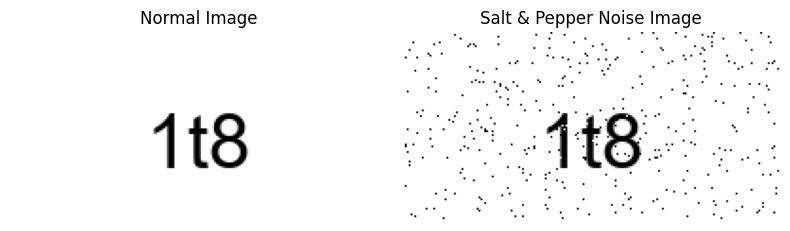

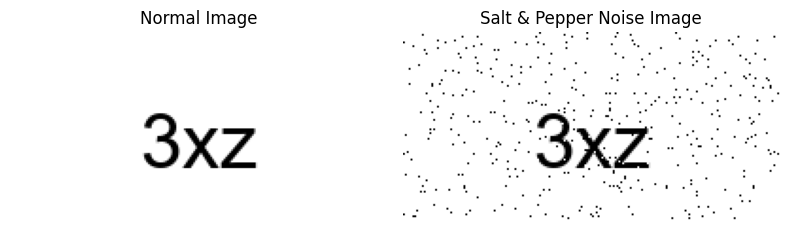

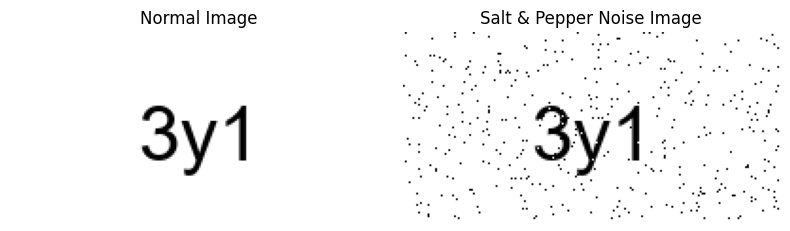

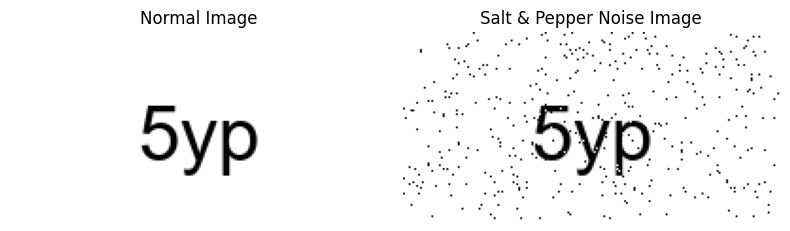

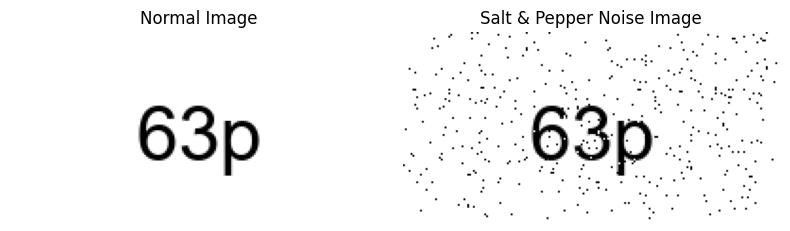

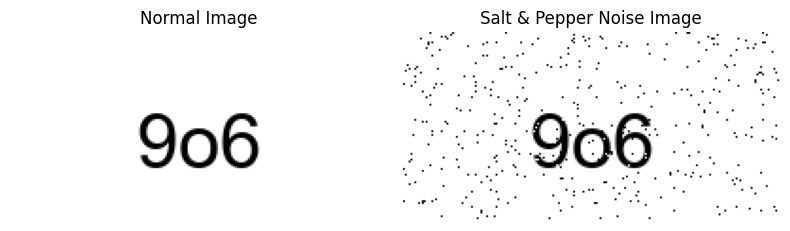

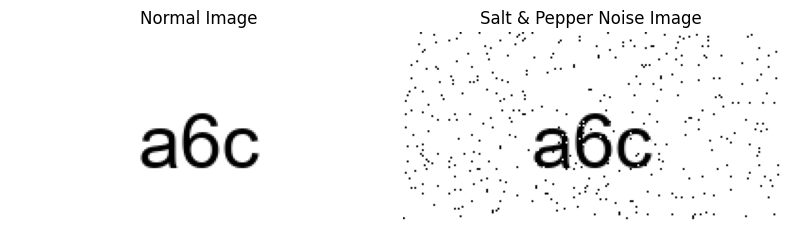

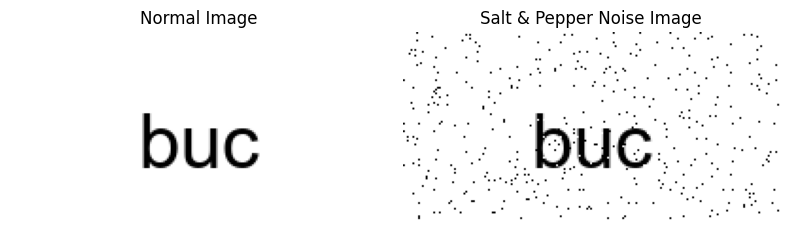

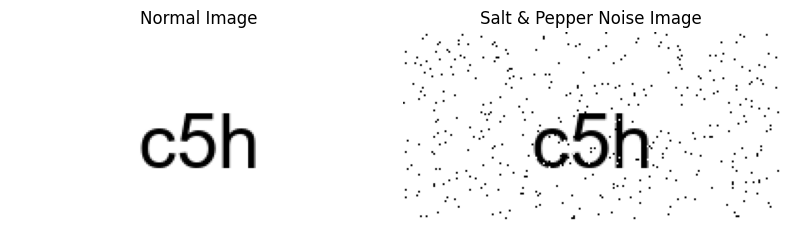

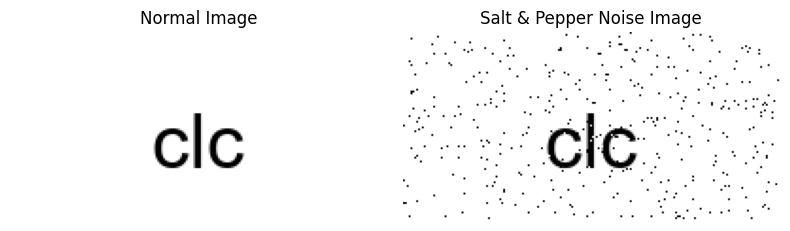

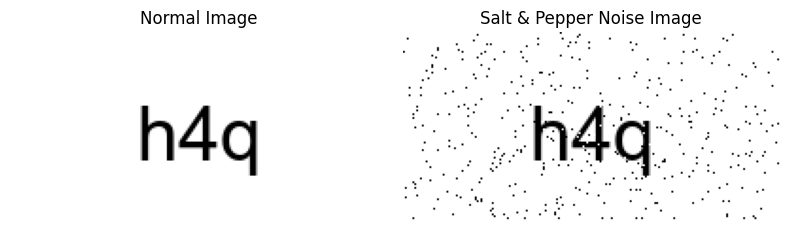

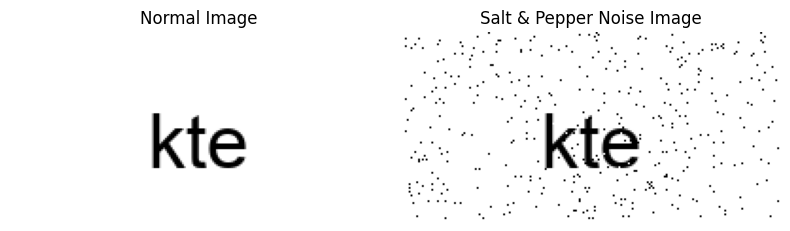

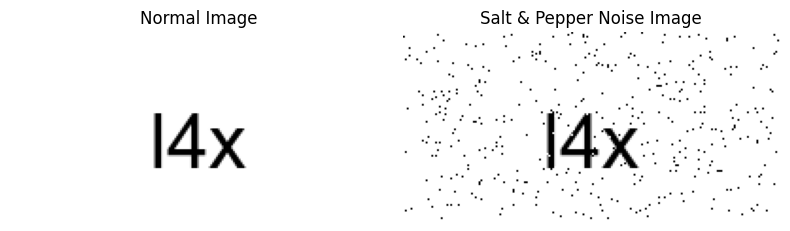

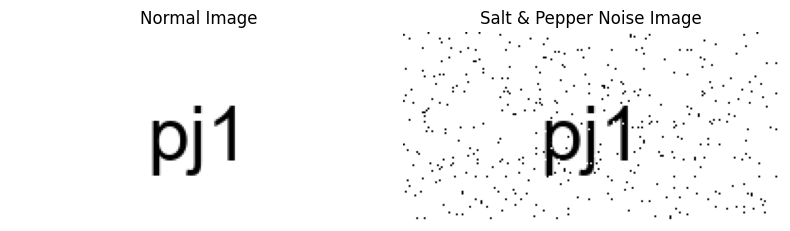

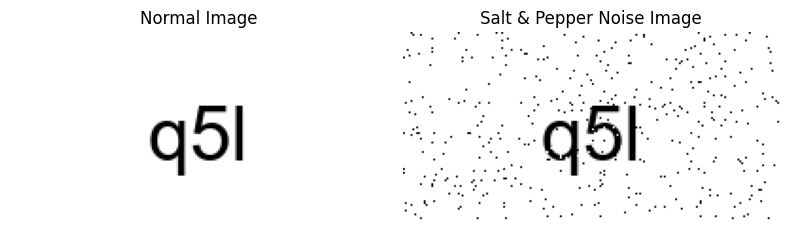

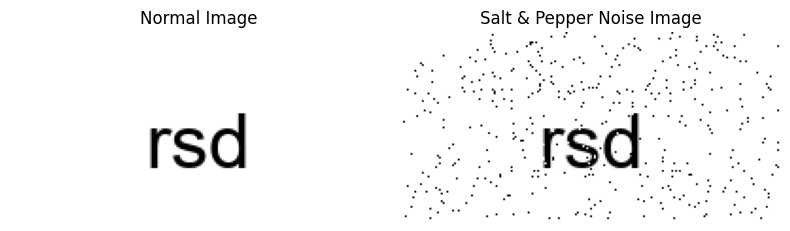

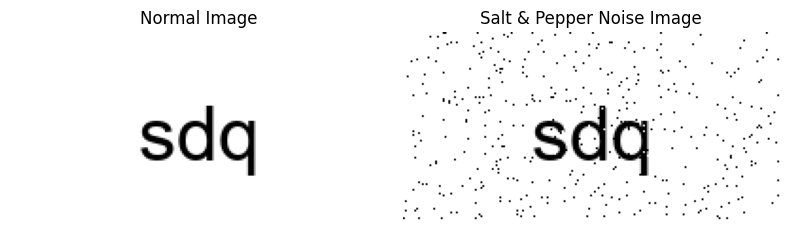

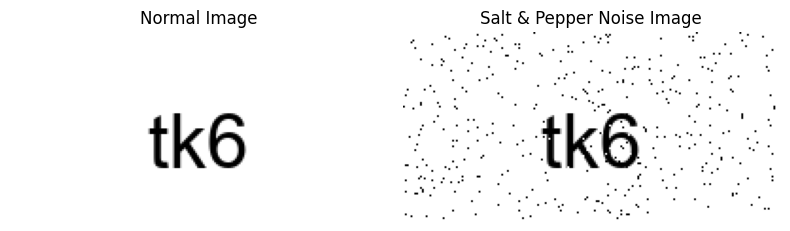

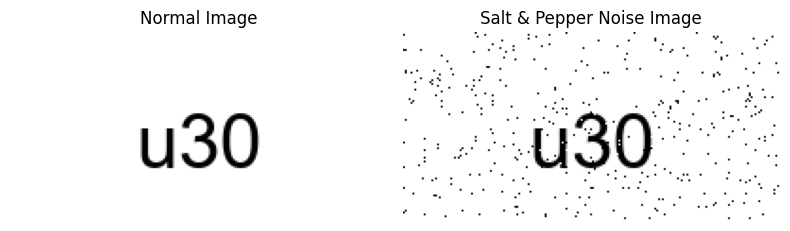

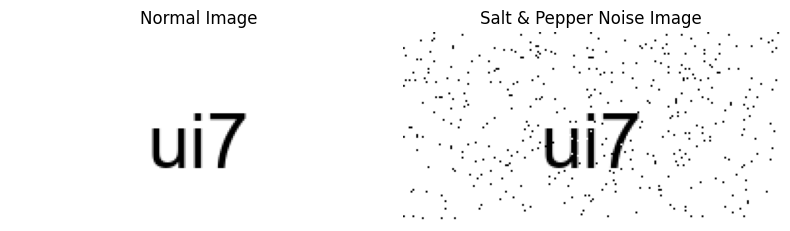

In [3]:
INPUT_DIR = "Captcha"
OUTPUT_DIR = "NoisyCaptcha"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def add_salt_pepper(image, salt_prob=0.02, pepper_prob=0.02):
    noisy = np.copy(image)
    h, w, _ = image.shape

    num_salt = np.ceil(salt_prob * h * w)
    num_pepper = np.ceil(pepper_prob * h * w)

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], :] = 255

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], :] = 0
    return noisy

for file in os.listdir(INPUT_DIR):
    if file.endswith(".png"):
        path = os.path.join(INPUT_DIR, file)
        img = cv2.imread(path)

        noisy_img = add_salt_pepper(img)

        out_path = os.path.join(OUTPUT_DIR, file)
        cv2.imwrite(out_path, noisy_img)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Normal Image")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Salt & Pepper Noise Image")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()


In [4]:
def median_filter(image, k=3):

    if k % 2 == 0 or k < 3:
        raise ValueError("k should be an odd number.")

    img = np.asarray(image)
    pad = k // 2

    if img.ndim == 2:
        img = img[..., None]

    h, w, c = img.shape
    padded = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode="reflect")

    out = np.empty_like(img)
    for ch in range(c):
        for y in range(h):
            y0, y1 = y, y + 2*pad + 1
            for x in range(w):
                x0, x1 = x, x + 2*pad + 1
                window = padded[y0:y1, x0:x1, ch]
                out[y, x, ch] = np.median(window)

    if out.shape[2] == 1:
        out = out[..., 0]
    return out

[info] Median kernel size = 5


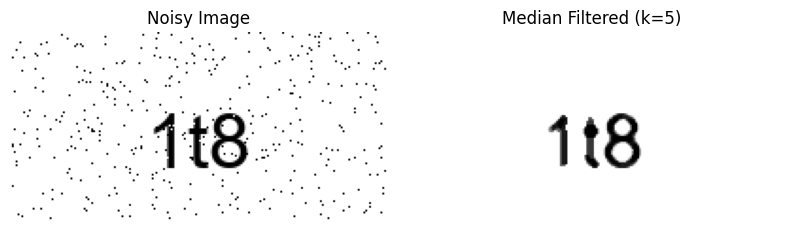

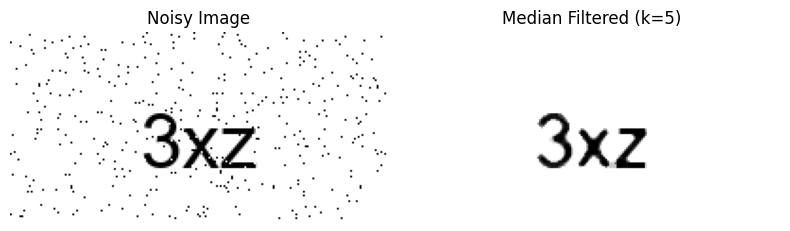

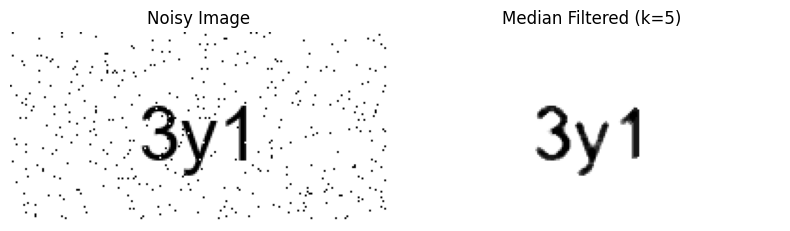

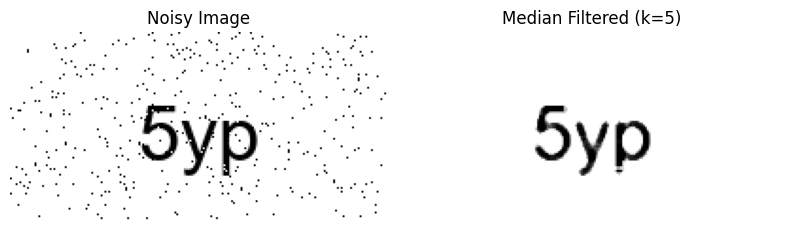

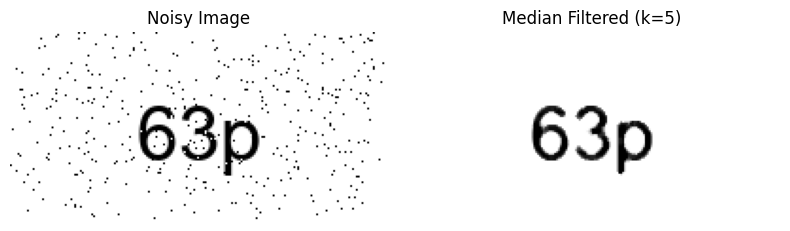

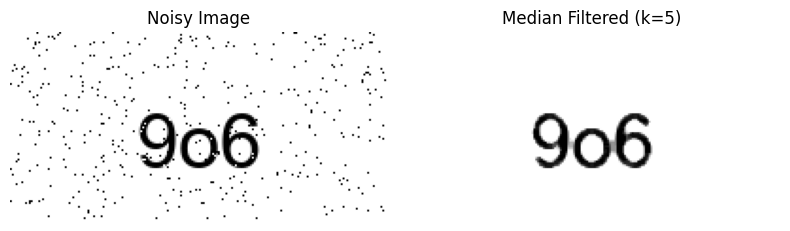

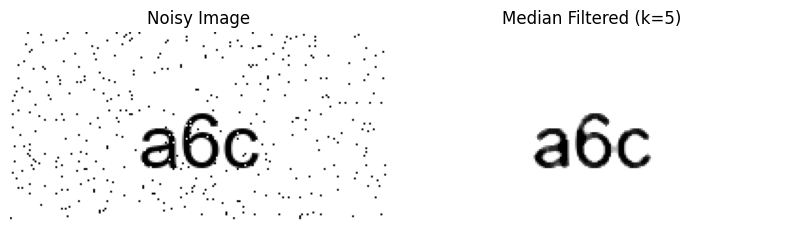

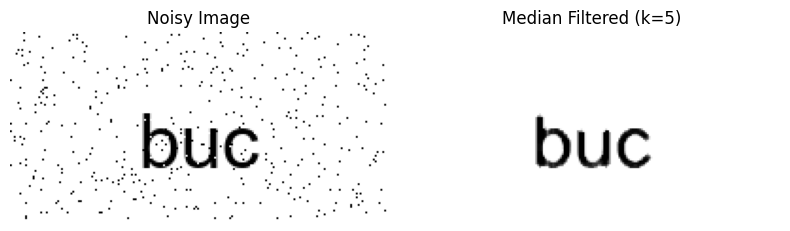

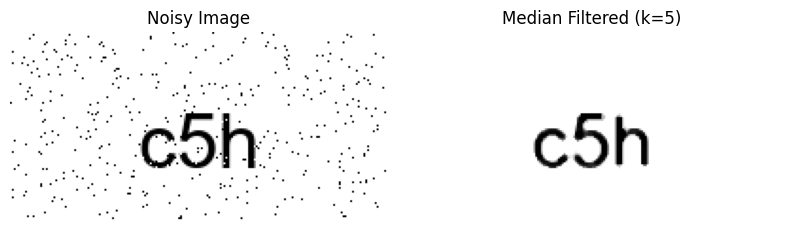

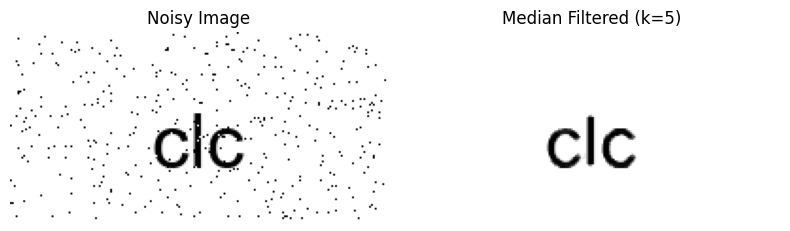

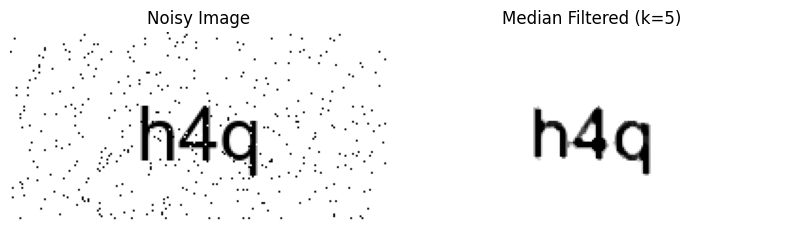

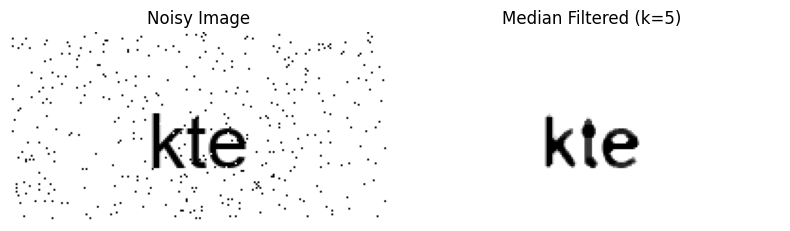

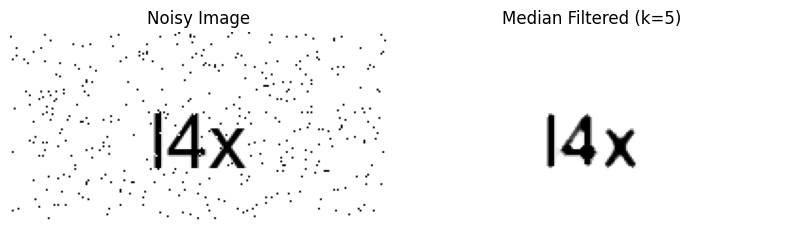

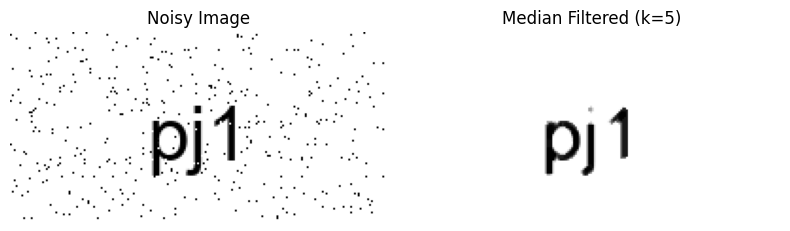

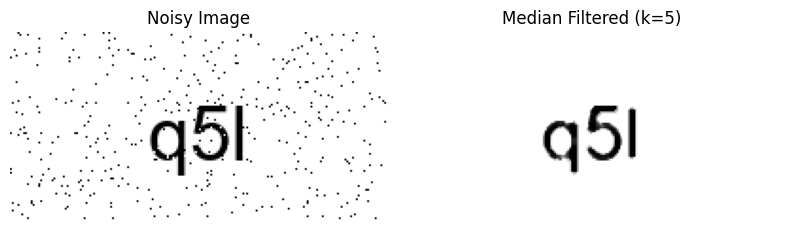

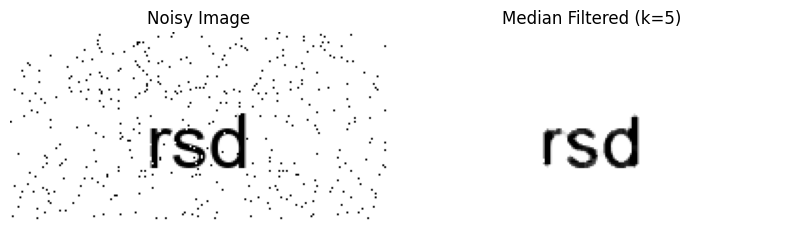

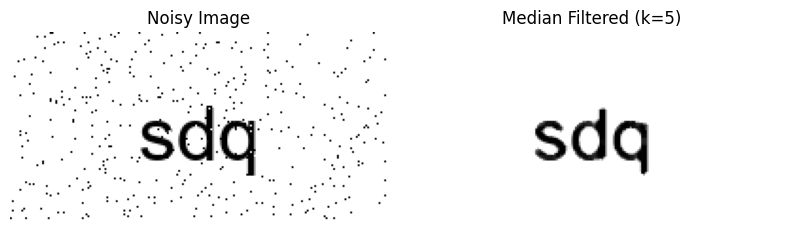

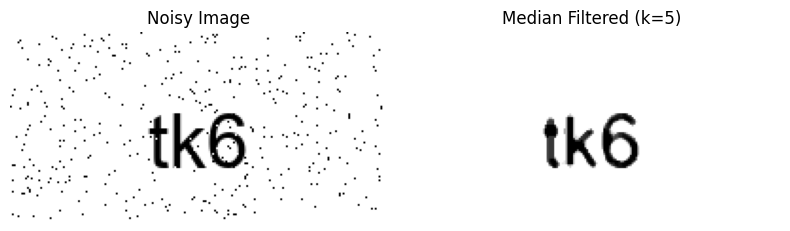

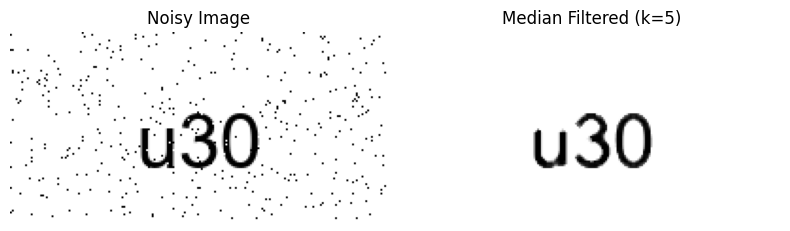

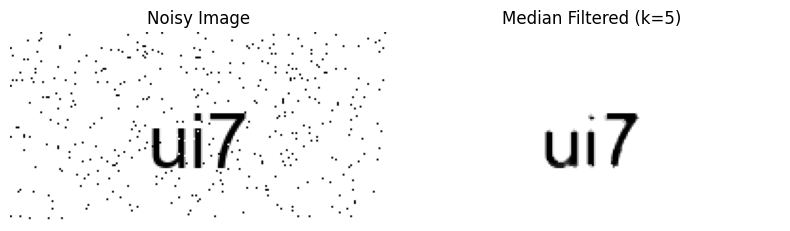

In [5]:
INPUT_DIR  = os.path.join("NoisyCaptcha")
OUTPUT_DIR = os.path.join("MedianBlurredCaptcha")
os.makedirs(OUTPUT_DIR, exist_ok=True)

k = 5
print(f"[info] Median kernel size = {k}")

files = [f for f in sorted(os.listdir(INPUT_DIR)) if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".webp"))]
if not files:
    raise SystemExit(f"[error] No images found in: {os.path.abspath(INPUT_DIR)}")

for file in files:
    path = os.path.join(INPUT_DIR, file)
    img = cv2.imread(path)
    if img is None:
        print(f"[warn] Could not read: {path}")
        continue

    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    blurred = cv2.medianBlur(img, k)
    out_path = os.path.join(OUTPUT_DIR, file)
    ok = cv2.imwrite(out_path, blurred)
    if not ok:
        print(f"[warn] Could not write: {out_path}")

    img_rgb     = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blurred_rgb = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_rgb)
    axes[0].set_title("Noisy Image")
    axes[0].axis("off")

    axes[1].imshow(blurred_rgb)
    axes[1].set_title(f"Median Filtered (k={k})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
def gaussian_filter(k: int, sigma: float):
    if k < 3 or k % 2 == 0:
        raise ValueError("k should be an odd number")
    if sigma <= 0:
        raise ValueError("sigma should be a positive number")

    r = (k - 1) // 2
    x = np.arange(-r, r + 1, dtype=np.float64)
    g1 = np.exp(-(x * x) / (2.0 * sigma * sigma))
    g1 /= g1.sum()

    kernel = np.outer(g1, g1)

    kernel /= kernel.sum()
    return kernel


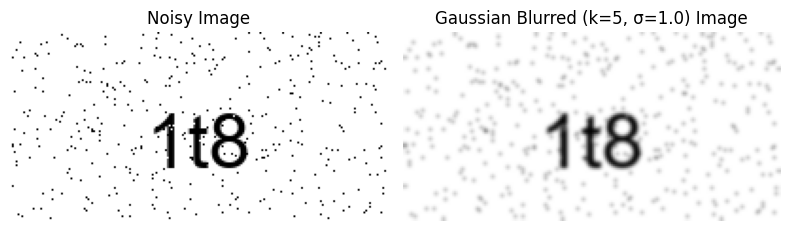

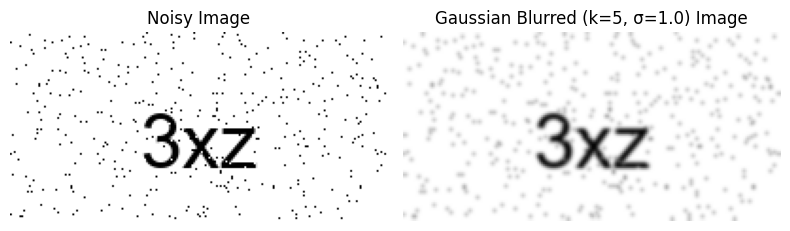

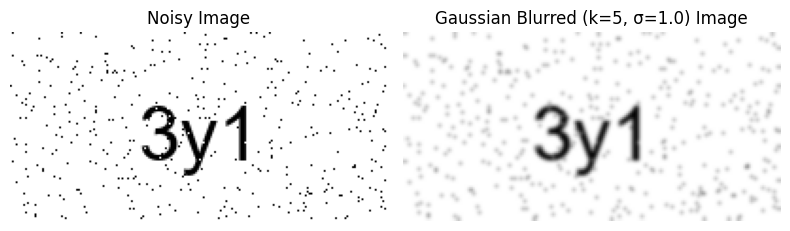

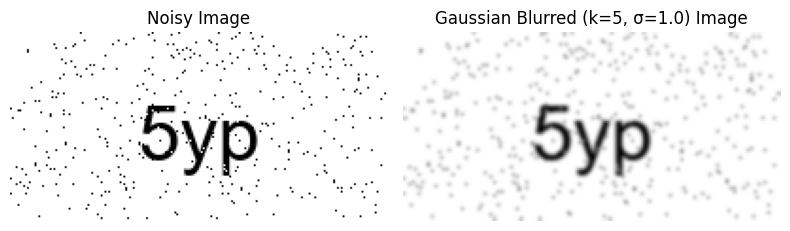

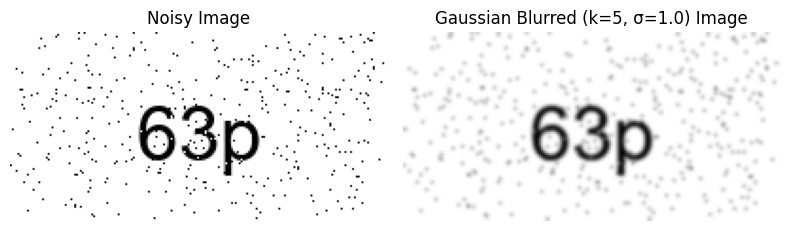

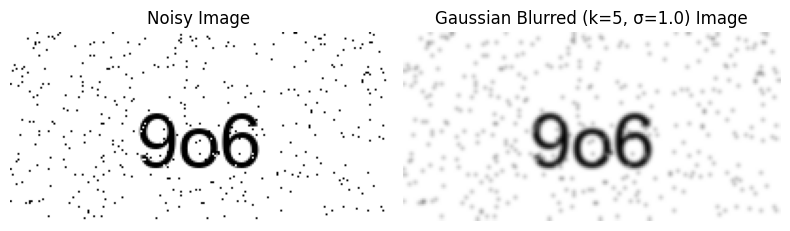

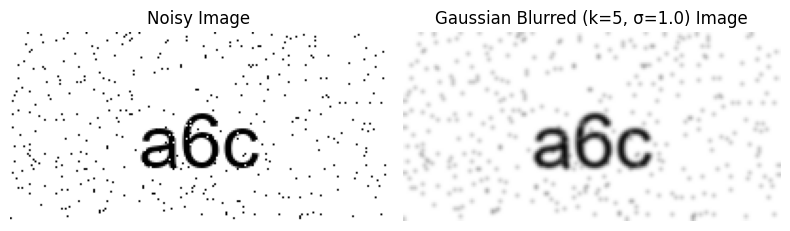

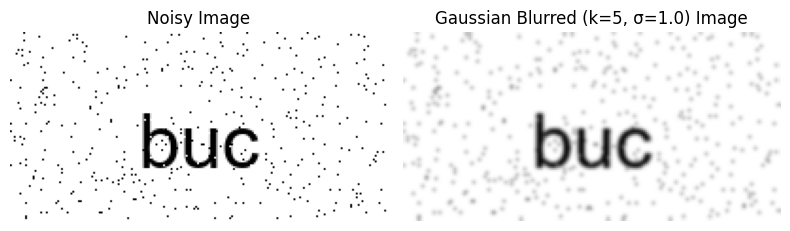

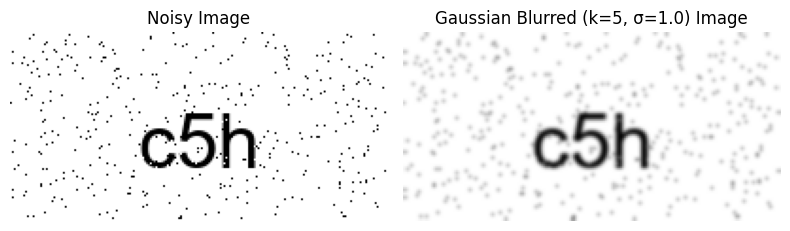

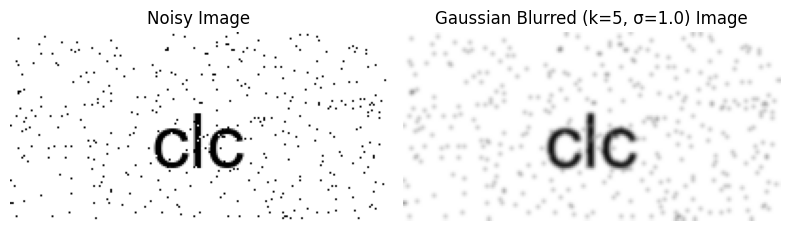

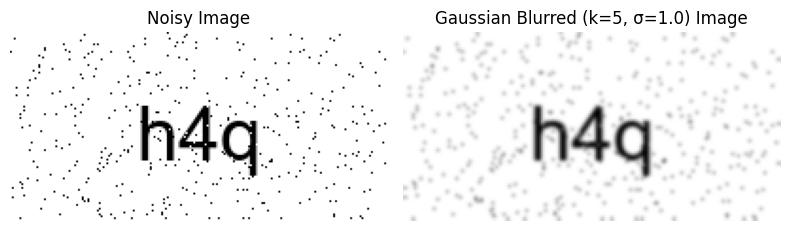

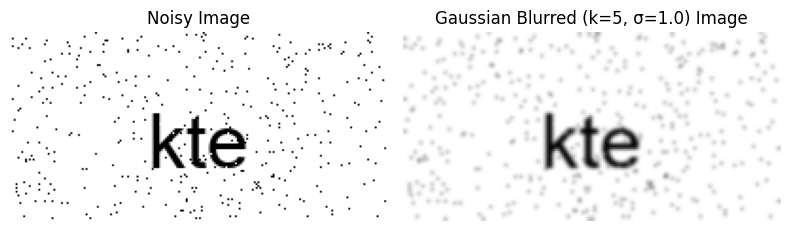

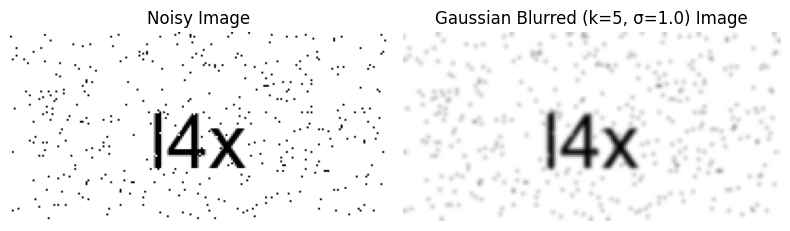

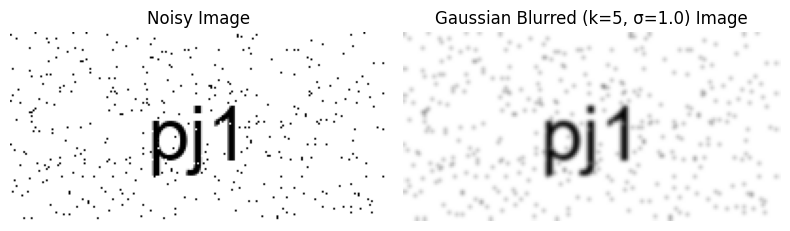

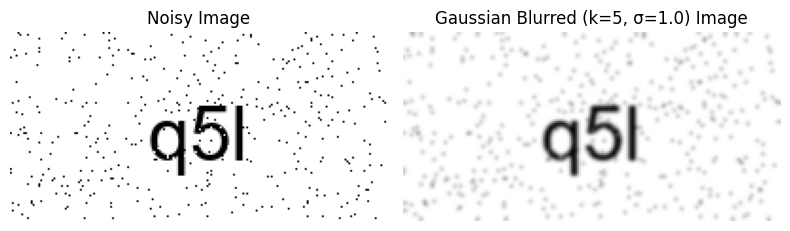

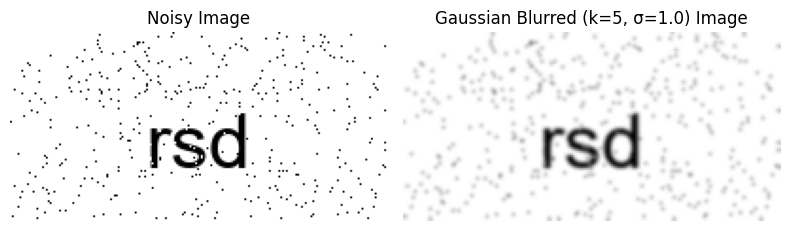

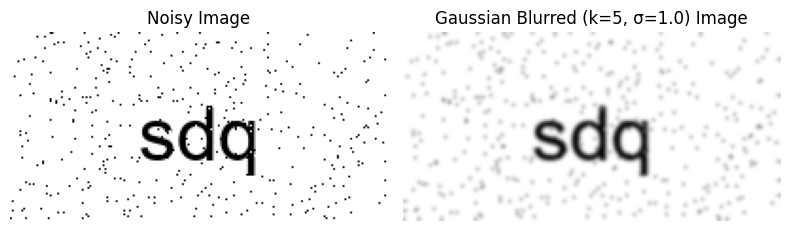

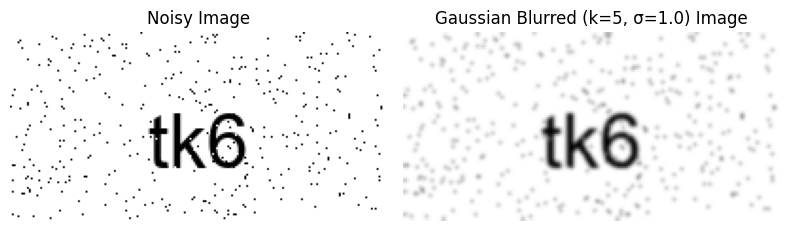

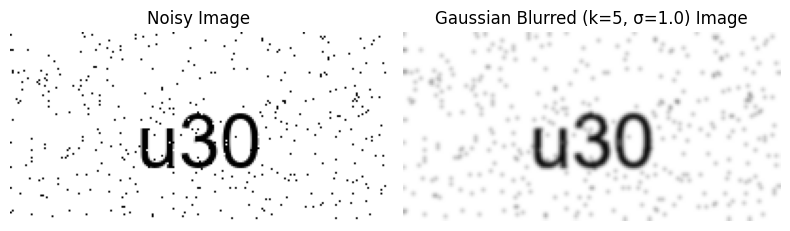

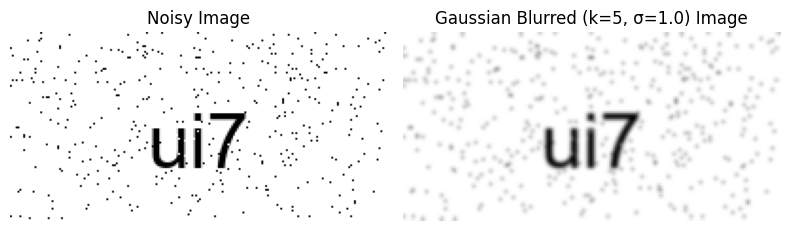

In [7]:
INPUT_DIR  = os.path.join("NoisyCaptcha")
OUTPUT_DIR = os.path.join("GaussianBlurredCaptcha")
os.makedirs(OUTPUT_DIR, exist_ok=True)

k = 5
sigma = 1.0
kernel = gaussian_filter(k, sigma)
for file in os.listdir(INPUT_DIR):
    if file.endswith(".png"):
        path = os.path.join(INPUT_DIR, file)
        img = cv2.imread(path)
        blurred = cv2.filter2D(img, -1, kernel)

        out_path = os.path.join(OUTPUT_DIR, file)
        cv2.imwrite(out_path, blurred)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title("Noisy Image")
        axes[0].axis("off")

        axes[1].imshow(blurred, cmap='gray')
        axes[1].set_title(f"Gaussian Blurred (k={k}, σ={sigma}) Image")
        axes[1].axis("off")
    
        plt.tight_layout()
        plt.show()


<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
برای کاهش نویز و محو کردن تصویر، در این پروژه از فیلتر گوسی (Gaussian Blur) با اندازه کرنل 
k=5 و انحراف معیار 
σ=1 استفاده شده است. ویژگی اصلی این فیلتر در نحوه وزن‌ دهی آن به پیکسل‌ هاست؛ بدین صورت که پیکسل‌ های نزدیک به مرکز بیشترین وزن را دریافت می‌ کنند و هرچه فاصله از مرکز بیشتر شود، سهم آن پیکسل در محاسبه مقدار جدید کمتر خواهد بود. این خاصیت باعث می‌ شود که تاری تصویر به‌ صورت تدریجی و طبیعی انجام شود، بدون اینکه لبه‌ های حروف به‌ طور محسوسی تخریب شوند. در این پروژه، کرنل گوسی به‌صورت دستی تولید و از طریق تابع کانولوشن بر روی تصویر اعمال شده است.
در مقابل، فیلترهای میانگین و میانه نیز گزینه‌ های متداولی برای حذف نویز هستند، اما هر یک محدودیت‌ هایی دارند. در فیلتر میانگین، مقدار هر پیکسل با میانگین ساده همسایه‌ هایش جایگزین می‌ شود. این روش گرچه نویز را کاهش می‌ دهد، اما در تصاویر متنی می‌ تواند موجب شود که مرز بین کاراکتر های نزدیک به‌هم از بین برود یا بخش‌ هایی از حروف به یکدیگر بچسبند. فیلتر میانه نیز که بر اساس میانه مقادیر همسایگی عمل می‌ کند، در حذف نویز فلفل‌ نمکی موثر است، اما گاهی باعث تغییرات ناخواسته در لبه‌ های دقیق حروف می‌ شود و شکل آن‌ ها را اندکی دگرگون می‌ کند.
استفاده از فیلتر گوسی این مشکلات را تا حد زیادی برطرف می‌ کند. چون وزن‌ دهی آن بر اساس توزیع نرمال انجام می‌ شود، مرزها به‌صورت ملایم حفظ می‌ شوند و تاری تصویر به شکلی یکنواخت گسترش می‌ یابد. به این ترتیب هم نویز پس‌ زمینه کاهش می‌ یابد و هم ساختار اصلی حروف دست ‌نخورده باقی می‌ ماند. این ویژگی در مراحل بعدی پردازش، مانند بخش‌ بندی (Segmentation)، اهمیت زیادی دارد؛ زیرا مانع از چسبیدن کاراکترهای مجاور به یکدیگر می‌ شود و باعث می‌ گردد الگوریتم بتواند هر حرف را به‌طور مستقل و دقیق شناسایی کند.
در مجموع، نتایج نشان دادند که فیلتر گوسی نسبت به فیلتر میانه و میانگین، خروجی نرم‌تر و یکنواخت‌ تری ارائه می‌ دهد، در حالی که جزییات اصلی تصویر همچنان حفظ می‌ شوند. به همین دلیل، در پردازش تصاویر متنی و آماده‌ سازی آن‌ ها برای تشخیص کاراکتر (OCR)، انتخاب فیلتر گوسی روشی بهینه و کارآمد محسوب می‌ شود.
</p>


<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
بخش دوم: پیش پردازش داده ها
</p>


<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
یکی از روش‌ های پایه و موثر در پیش‌ پردازش تصاویر برای کاهش نویز، استفاده از فیلترهای تارکننده (Blur Filters) است. اساس کار این فیلتر ها بر مبنای کاهش تغییرات ناگهانی در شدت روشنایی پیکسل‌ هاست. در واقع نویز معمولا به صورت تغییرات سریع و تصادفی در مقادیر شدت روشنایی یا رنگ پیکسل‌ ها ظاهر می‌ شود، در حالی که ساختارهای اصلی تصویر (مانند لبه‌ ها، خطوط و اشکال معنادار) معمولا تغییراتی تدریجی و پیوسته دارند. فیلترهای تارکننده با اعمال یک میانگین‌ گیری مکانی بر روی نواحی کوچک از تصویر، این تغییرات شدید و تصادفی را هموار می‌ کنند و در نتیجه انرژی فرکانس‌ های بالا که معرف نویز هستند کاهش می‌ یابد.
<br>
در این فرآیند، مقدار هر پیکسل جدید بر اساس مقادیر پیکسل‌ های مجاورش محاسبه می‌ شود؛ به‌عبارت دیگر، هر پیکسل از اطلاعات همسایگی خود تاثیر می‌ گیرد. این میانگین‌ گیری باعث می‌ شود که مقادیر پرت و ناهنجار (که اغلب ناشی از نویز هستند) در تصویر نهایی تاثیر کمتری داشته باشند. به‌صورت تحلیلی، فیلترهای Blur مانند یک فیلتر پایین‌ گذر (Low-pass filter) در حوزه‌ی فرکانس عمل می‌ کنند که مولفه‌های نویز را تضعیف و مولفه‌های آهسته‌ تر (ساختارهای اصلی) را حفظ می‌ کنند.
<br>
فیلترهای گوسی، میانگین، میانه و دوجانبه از جمله رایج‌ ترین فیلترهای تاری هستند که هر یک بسته به نوع نویز و حساسیت لبه‌ ها کاربرد خاصی دارند. برای مثال فیلتر گوسی (Gaussian Blur) با وزن‌دهی بیشتر به پیکسل‌ های نزدیک مرکز، تاری ملایمی ایجاد می‌ کند و لبه‌ها را نسبتا حفظ می‌ کند. در مقابل فیلتر میانه (Median Filter) در حذف نویزهای ضربه ای مانند نویز فلفل‌ نمکی موثرتر است زیرا مقدار میانه را انتخاب می‌ کند نه میانگین را. به‌طور کلی، هدف اصلی در استفاده از فیلترهای تاری این است که نویزهای تصادفی حذف شوند، در حالی‌ که ساختار و شکل کلی اجزای تصویر (مانند حروف و مرزها) تا حد امکان دست‌ نخورده باقی بمانند.
<br>
به این ترتیب، استفاده از فیلترهای Blur پیش از مراحل بعدی پردازش مانند بخش‌ بندی (Segmentation) یا تشخیص کاراکتر (OCR) بسیار مفید است، زیرا با حذف تغییرات ناگهانی و کاهش نویز، داده‌ ی ورودی به الگوریتم‌ های بعدی پایدارتر و قابل اعتمادتر می‌ شود. در نتیجه، فیلترهای تارکننده را می‌ توان به‌عنوان یکی از نخستین و مهم‌ ترین ابزارها در بهبود کیفیت داده‌ های تصویری در نظر گرفت.
</p>

<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
در این مرحله برای کاهش نویز از فیلتر Bilateral استفاده شد. این فیلتر نسبت به فیلتر های ساده ‌تر مانند Gaussian یا Median عملکرد دقیق‌ تری دارد، زیرا علاوه بر فاصله مکانی پیکسل‌ ها، تفاوت شدت روشنایی آن ‌ها را نیز در محاسبه وزن دخیل می‌ کند. به این ترتیب، Bilateral قادر است در نواحی صاف تصویر، نویز را به‌ طور قابل توجهی کاهش دهد، در حالی که در نواحی دارای مرز یا تغییرات شدید روشنایی (مانند لبه‌های کاراکترها) از محو شدن جزییات جلوگیری می‌ کند.
در نتیجه، خروجی این فیلتر تصویری است با پس‌ زمینه‌ای یکنواخت‌ تر و حروف واضح‌ تر که در مراحل بعدی پردازش مانند بخش‌ بندی (Segmentation) و تشخیص کاراکتر (OCR) دقت بیشتری را فراهم می‌ کند.
</p>

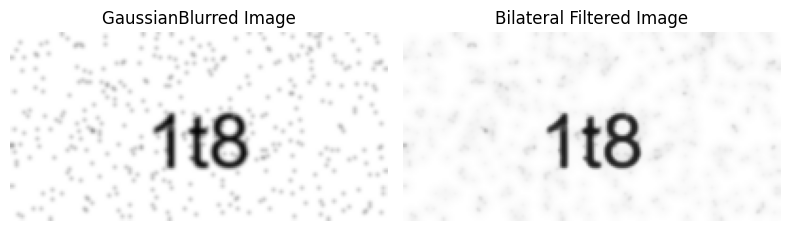

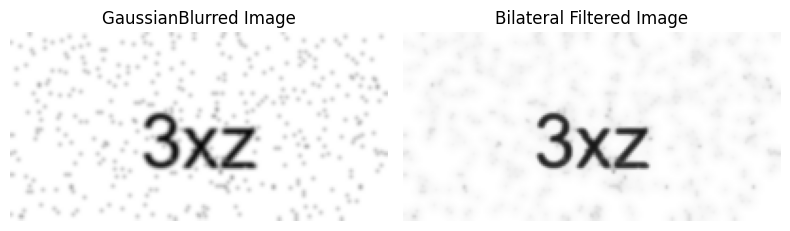

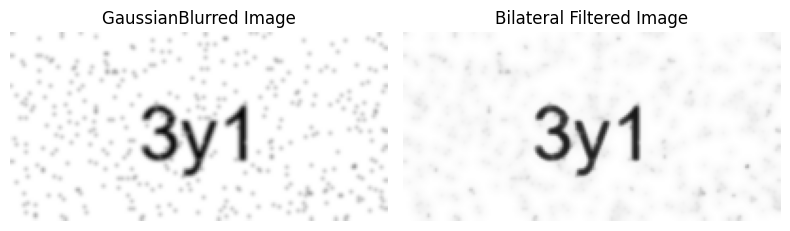

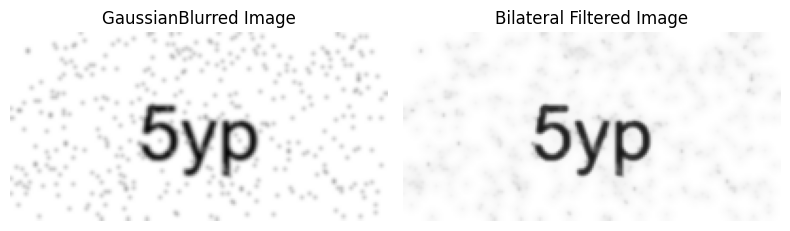

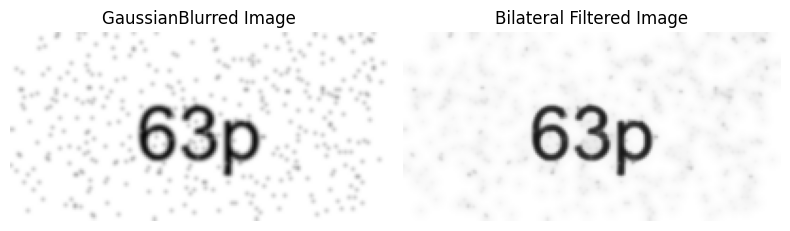

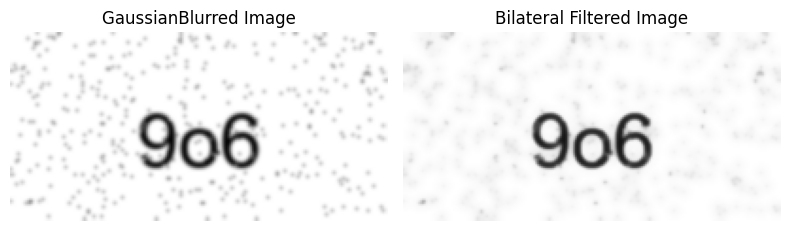

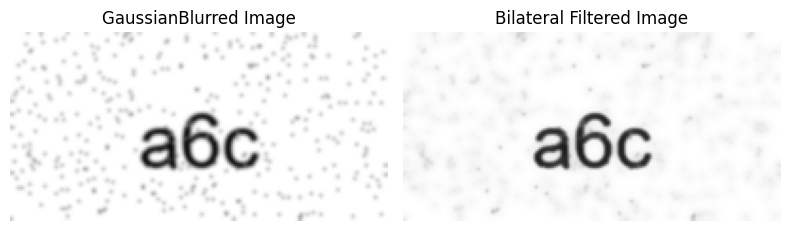

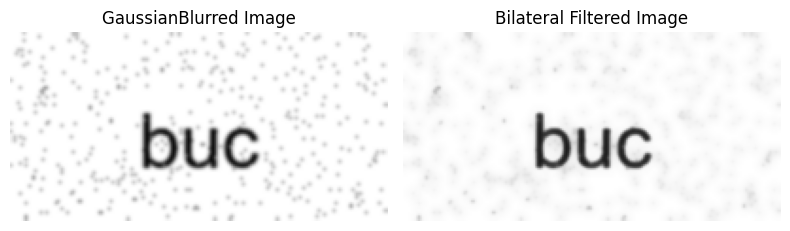

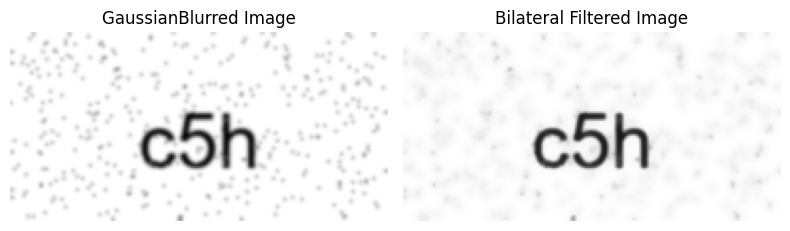

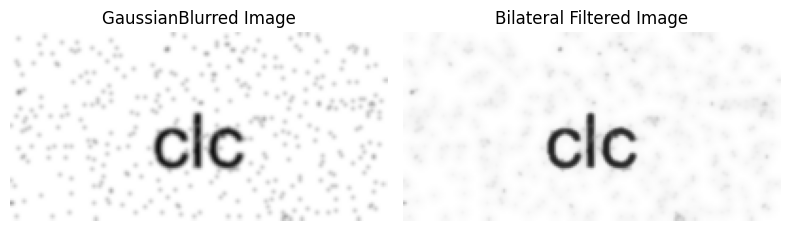

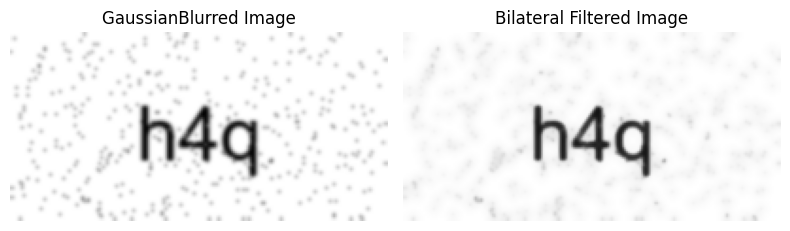

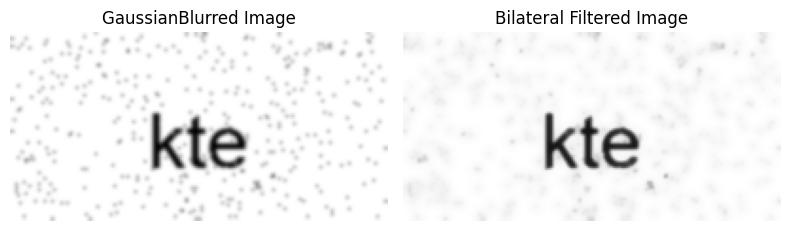

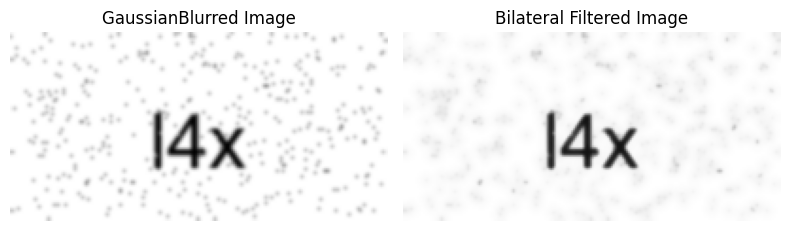

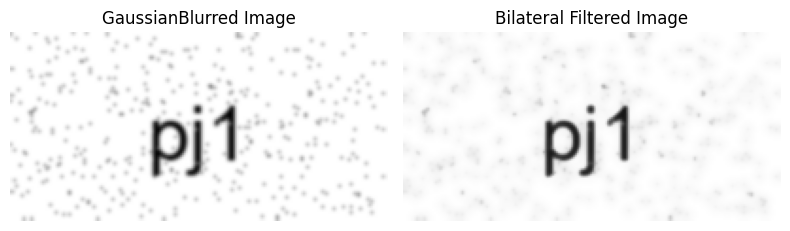

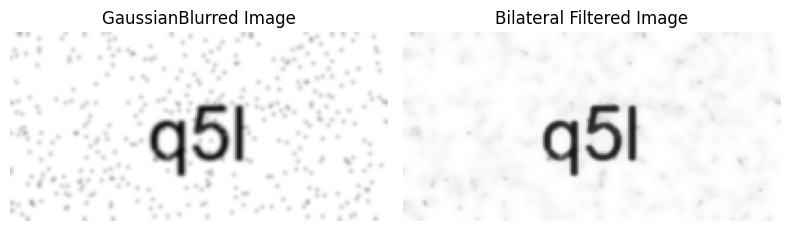

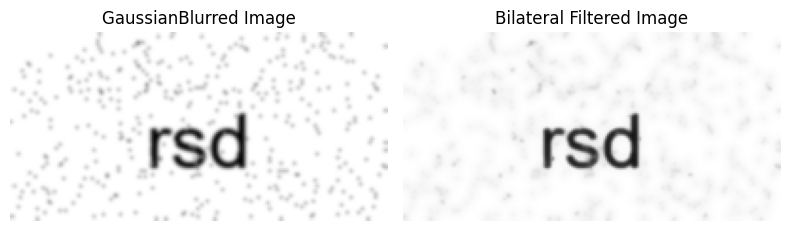

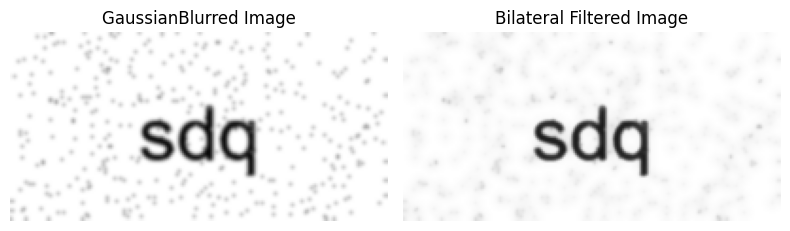

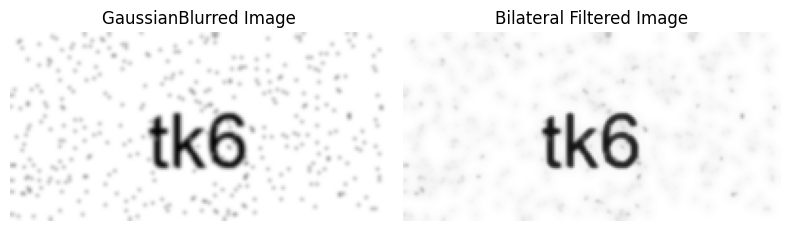

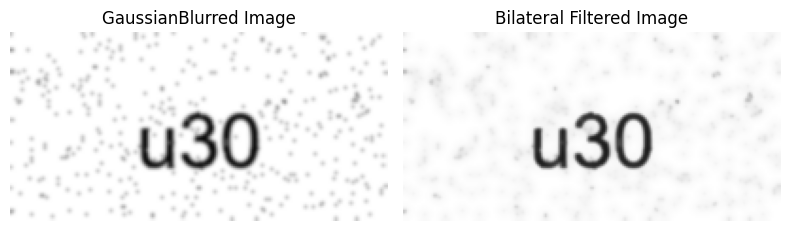

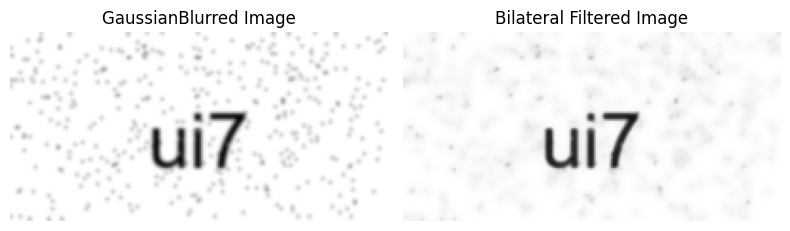

In [8]:
INPUT_DIR = os.path.join("GaussianBlurredCaptcha")
OUTPUT_DIR = os.path.join("BilateralCaptcha")
os.makedirs(OUTPUT_DIR, exist_ok=True)

diameter = 9
sigma_color = 75
sigma_space = 75

for file in os.listdir(INPUT_DIR):
    if file.endswith(".png"):
        path = os.path.join(INPUT_DIR, file)
        img = cv2.imread(path)

        filtered = cv2.bilateralFilter(img, d=diameter,
                                       sigmaColor=sigma_color,
                                       sigmaSpace=sigma_space)

        out_path = os.path.join(OUTPUT_DIR, file)
        cv2.imwrite(out_path, filtered)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title("GaussianBlurred Image")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Bilateral Filtered Image")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
پس از اعمال فیلترهای تاری و کاهش نویز، ممکن است تصویر تا حدی از وضوح اولیه‌ ی خود فاصله بگیرد. در چنین شرایطی لازم است از فیلترهایی استفاده شود که بتوانند لبه‌ ها و جزییات از دست‌ رفته را بازسازی و تصویر را واضح‌ تر کنند. این فرآیند در پردازش تصویر با عنوان‌ های De-blurring (حذف تاری) و Sharpening (تیزسازی) شناخته می‌ شود.
<br>
در فیلترهای تاری، معمولا مقادیر پیکسل‌ ها با میانگین همسایه‌ ها جایگزین می‌ شود و این باعث از بین رفتن تغییرات سریع در شدت روشنایی می‌ گردد. هرچند این روش در کاهش نویز موثر است، اما در عین حال موجب از بین رفتن لبه‌ ها و جزییات ظریف تصویر می‌ شود. فیلترهای Sharpening برعکس عمل می ‌کنند؛ یعنی تغییرات سریع در شدت روشنایی را تقویت می‌ کنند تا مرز بین نواحی مختلف در تصویر واضح‌ تر دیده شود. از نظر مفهومی، این فیلترها مشابه یک فیلتر بالاگذر (High-pass filter) در حوزه‌ ی فرکانس عمل می‌ کنند، زیرا اجزای با تغییر سریع (لبه‌ها) را تقویت و اجزای هموار (نواحی یکنواخت) را کمتر تاثیر می‌ دهند.
<br>
در روش‌ های De-blurring نیز هدف مشابه است، اما با تاکید بر بازسازی اطلاعات از دست‌ رفته در اثر تاری حرکتی یا Gaussian blur. این روش‌ ها معمولا از مدل‌ سازی ریاضی فیلتر تاری (kernel) استفاده می‌ کنند و با معکوس‌ سازی یا تخمین آن تلاش می‌ کنند تصویر اصلی را بازسازی نمایند. در کاربردهای ساده‌ تر، می‌ توان از فیلترهای تیزکننده‌ ای مانند Unsharp Mask یا Laplacian Filter استفاده کرد که با ترکیب تصویر اصلی و نسخه‌ ی تار آن، مرزها را برجسته‌ تر کرده و در نتیجه تصویر واضح‌ تر به‌نظر می‌ رسد.
</p>


Kernel:
 [[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]


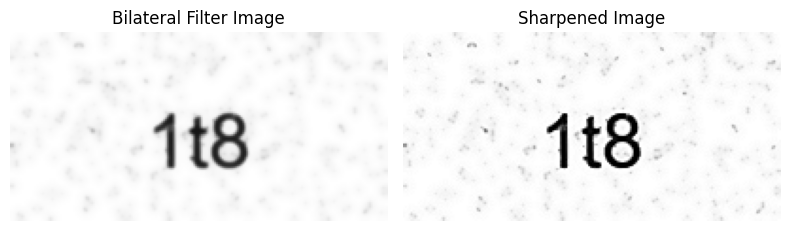

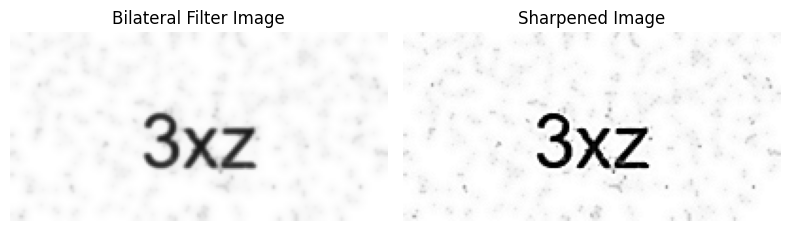

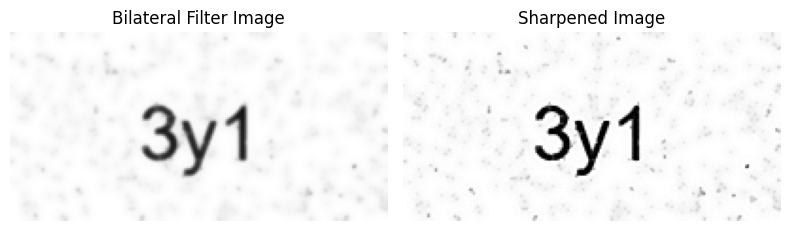

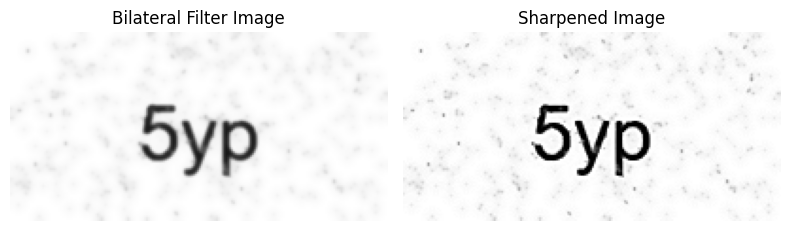

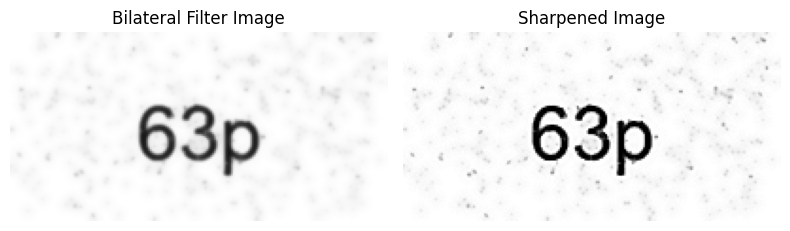

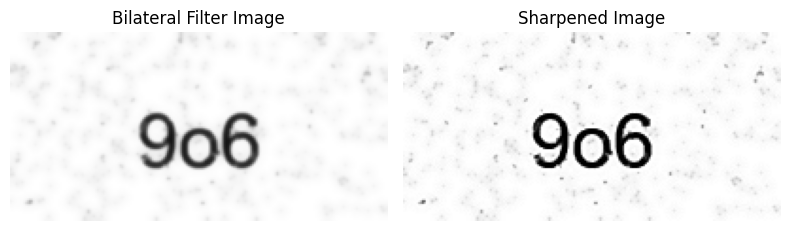

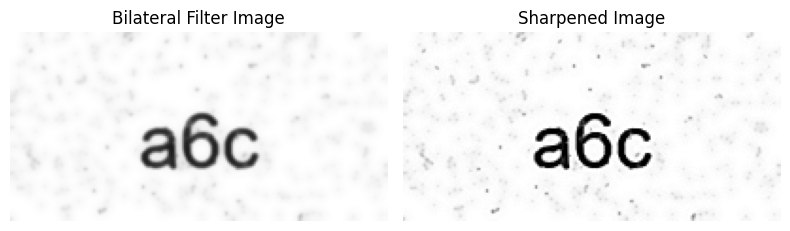

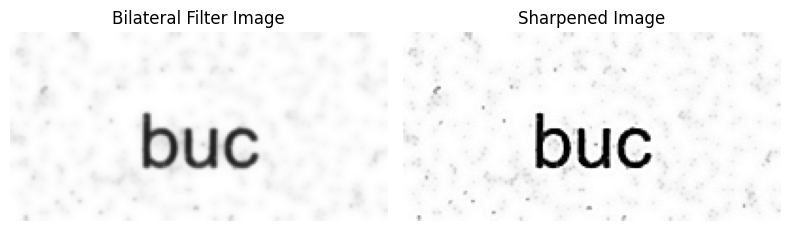

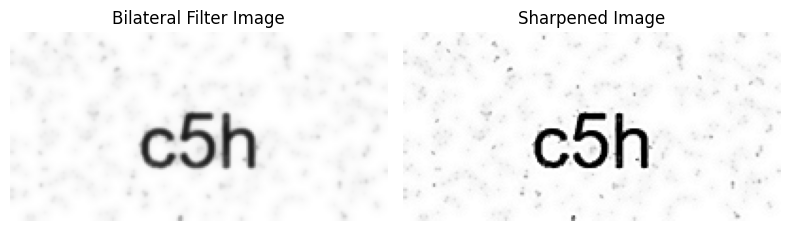

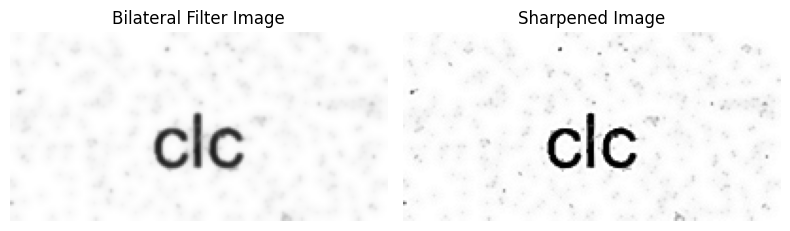

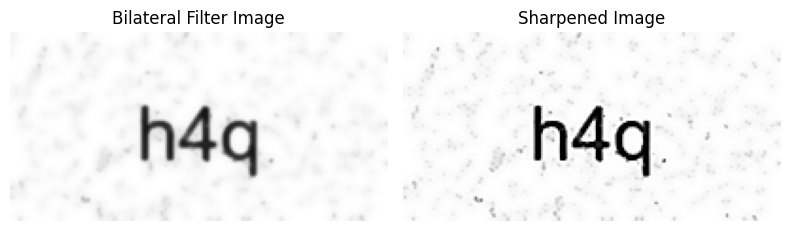

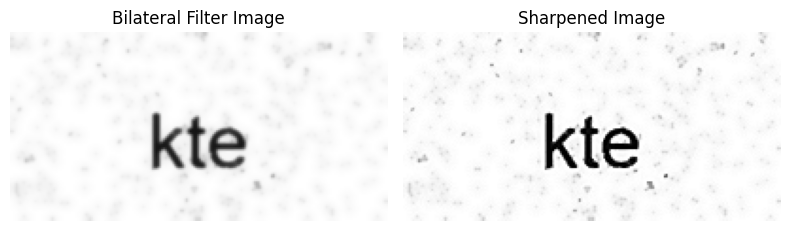

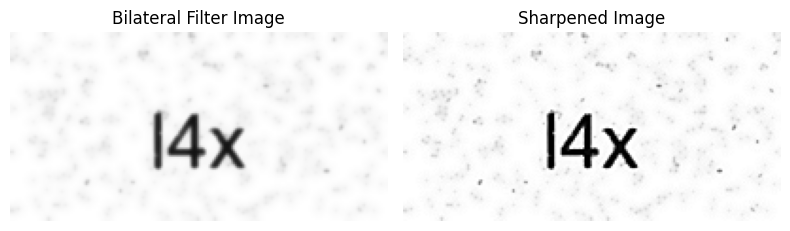

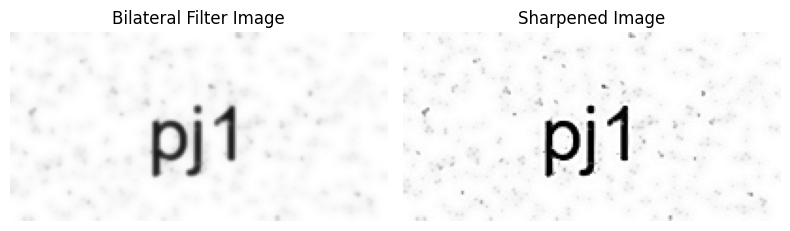

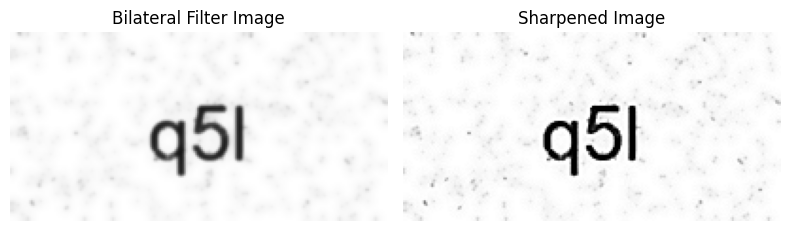

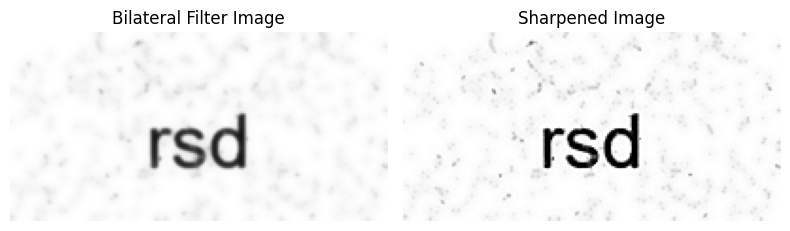

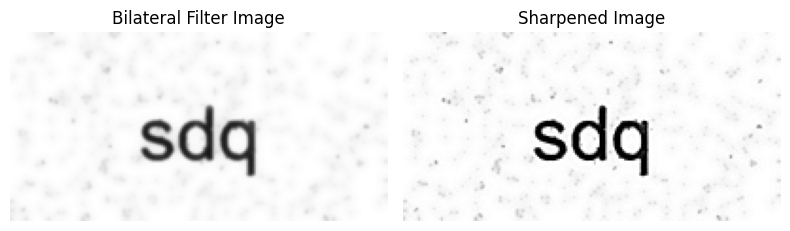

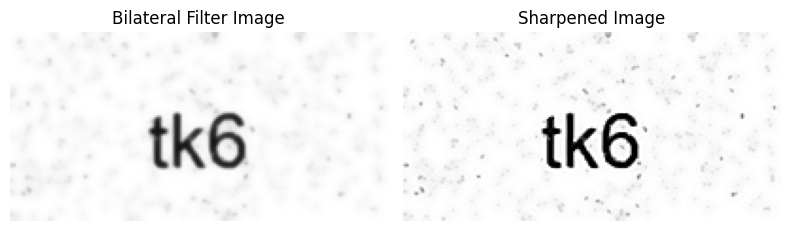

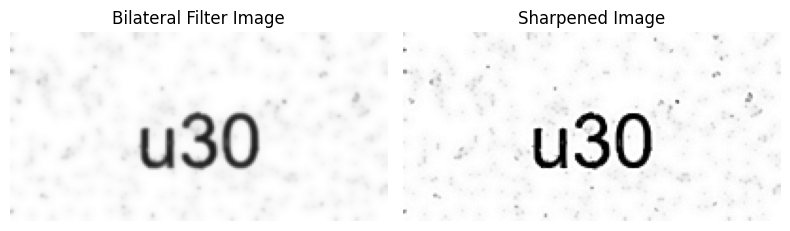

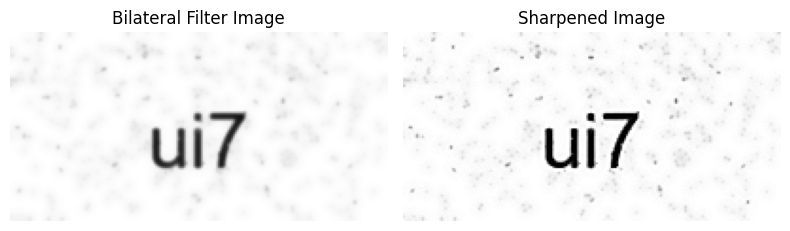

In [9]:
INPUT_DIR = os.path.join("BilateralCaptcha")
OUTPUT_DIR = os.path.join("SharpenedCaptcha")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def highboost_kernel(alpha: float = 1.0):
    k = np.array([[0,        -alpha,       0],
                  [-alpha, 1+4*alpha, -alpha],
                  [0,        -alpha,       0]], dtype=np.float32)
    return k

alpha = 1.0
kernel = highboost_kernel(alpha)
print("Kernel:\n", kernel)

for file in os.listdir(INPUT_DIR):
    if file.endswith(".png"):
        path = os.path.join(INPUT_DIR, file)
        img = cv2.imread(path)

        sharpened = cv2.filter2D(img, -1, kernel)

        out_path = os.path.join(OUTPUT_DIR, file)
        cv2.imwrite(out_path, sharpened)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title("Bilateral Filter Image")
        axes[0].axis("off")

        axes[1].imshow(sharpened, cmap='gray')
        axes[1].set_title("Sharpened Image")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
پس از حذف نویز و اعمال فیلترهای تارکننده در مراحل قبلی، هرچند نویز تصویر کاهش یافت و پس‌ زمینه یکنواخت‌ تر شد، اما لبه‌ ها و جزییات ظریف حروف تا حدی محو شدند. برای بازگرداندن وضوح اولیه‌ ی تصویر، در این مرحله از فیلتر Sharpening با کرنل High-Boost استفاده شد که با تابع filter2D پیاده‌ سازی گردید. این روش نسبت به سایر روش‌ های تیزسازی، کنترل‌ پذیری بالاتری دارد و می‌ توان با تغییر پارامتر α میزان تقویت لبه‌ ها را دقیقا تنظیم کرد.
<br>
ایده‌ ی اصلی این فیلتر بر پایه‌ ی ترکیب تصویر اصلی با نسخه‌ ای از خودش است که به‌صورت نرم‌ تر (blur) شده است. با محاسبه‌ ی اختلاف بین این دو نسخه، اطلاعات مربوط به لبه‌ ها و تغییرات سریع در شدت روشنایی استخراج می‌ شود و سپس با ضریب α به تصویر اصلی افزوده می‌ گردد. نتیجه‌ ی این فرآیند، تصویری است که مرزها و خطوط در آن واضح‌ تر و برجسته‌ تر دیده می‌ شوند، در حالیکه نواحی صاف تصویر (مانند پس‌ زمینه‌ی سفید) تقریبا بدون تغییر باقی می‌ مانند.
<br>
از آنجا که در این پروژه هدف اصلی تشخیص و تفکیک دقیق کاراکترهاست، وضوح لبه ‌ها اهمیت ویژه‌ای دارد. اگر حروف تار یا نرم باقی بمانند، الگوریتم‌های بخش‌ بندی و شناسایی کاراکترها در مراحل بعدی ممکن است حروف نزدیک به‌هم را به‌ عنوان یک بخش واحد تشخیص دهند یا مرز بین آن‌ ها را به‌درستی شناسایی نکنند. فیلتر High-Boost با تقویت گرادیان در ناحیه‌ ی مرز حروف، این مشکل را برطرف می‌ کند و باعث می‌ شود لبه‌ ی کاراکترها واضح‌ تر و قابل تفکیک‌ تر باشند.
<br>
همچنین استفاده از تابع filter2D این مزیت را دارد که فرآیند تیزسازی به‌صورت مستقیم و موثر با استفاده از یک ماتریس کرنل انجام می‌ شود، بدون نیاز به مراحل اضافی یا محاسبات سنگین. به این ترتیب، روش انتخابی علاوه بر کیفیت مناسب خروجی، از نظر سرعت و سادگی نیز برای پروژه‌های بینایی ماشین و OCR گزینه‌ای بهینه محسوب می‌ شود.
</p>


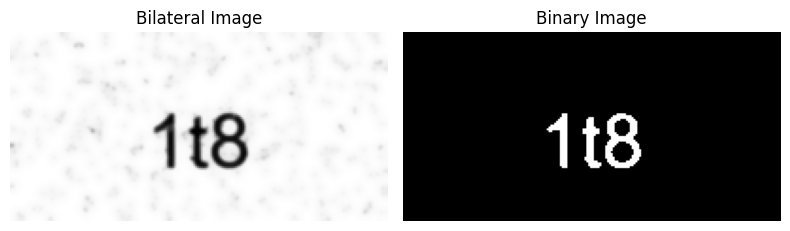

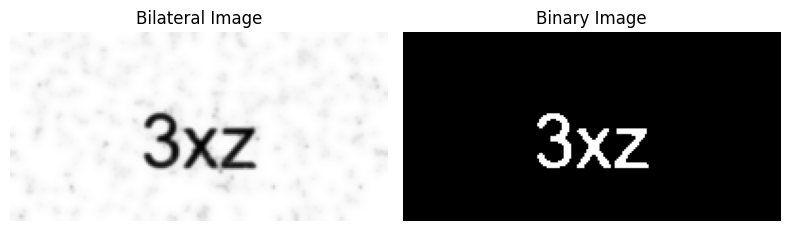

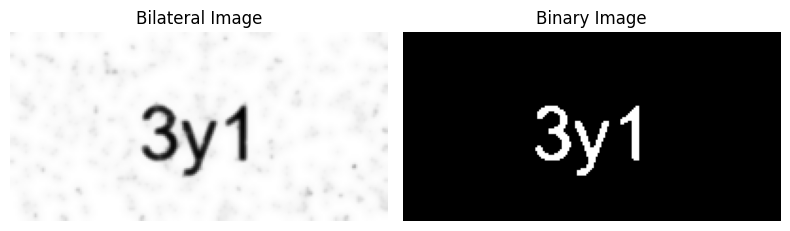

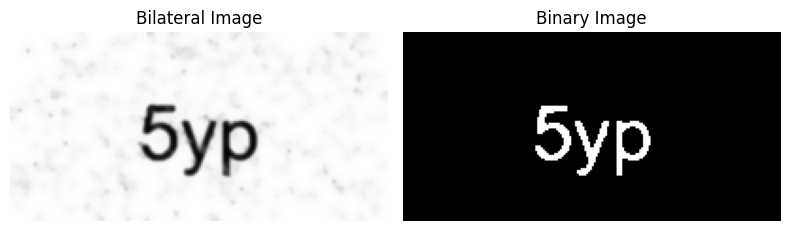

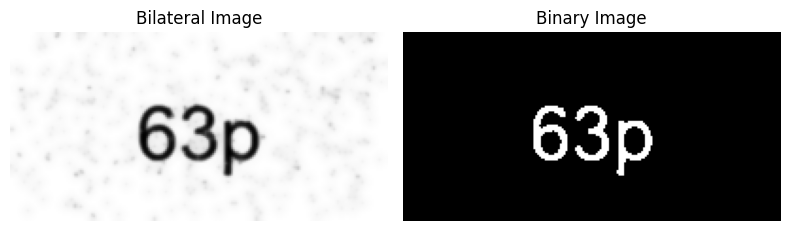

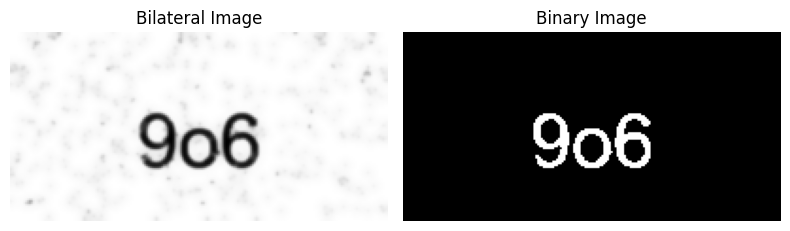

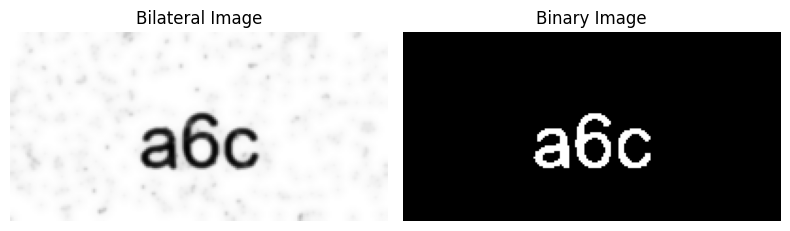

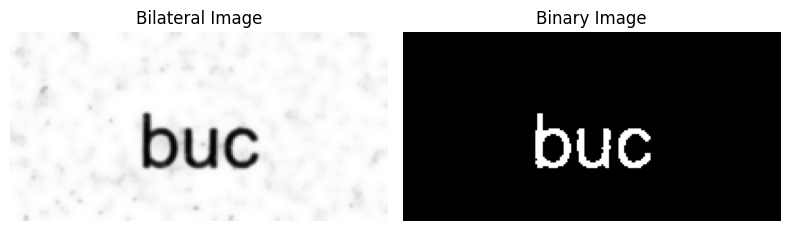

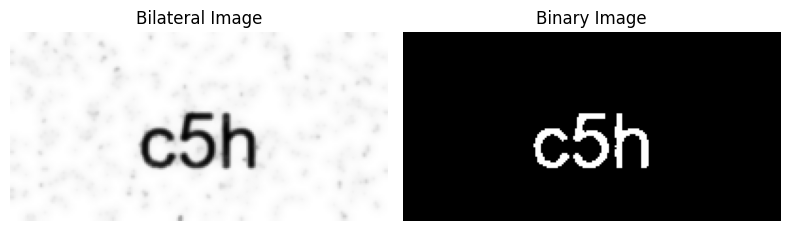

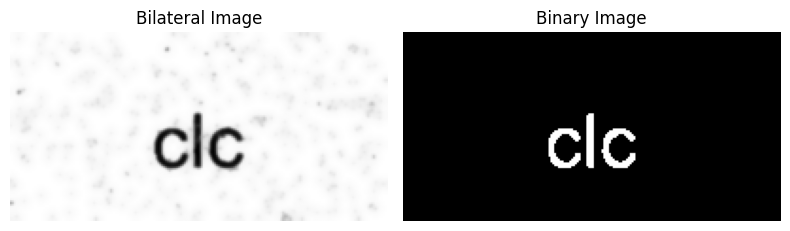

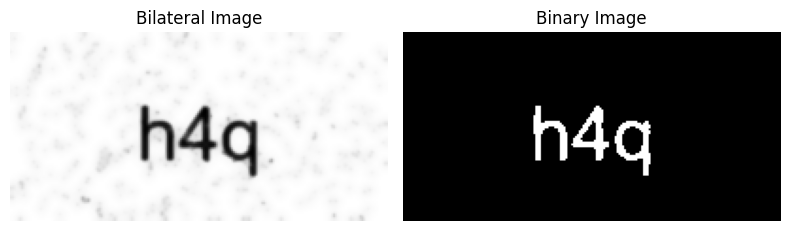

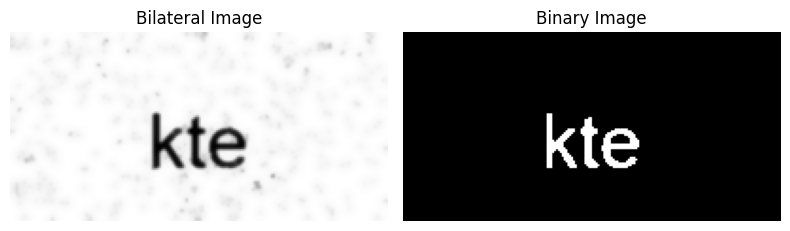

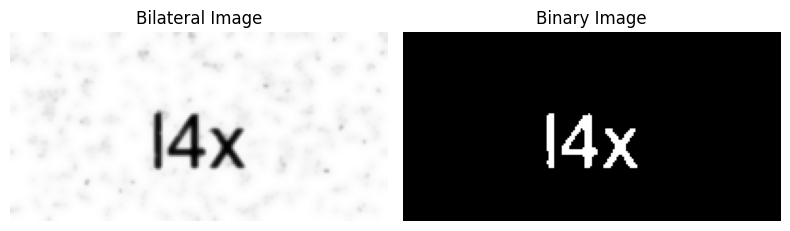

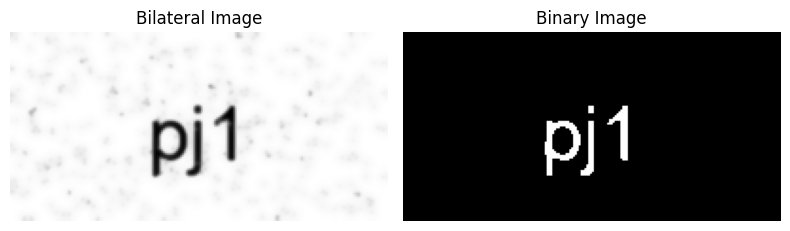

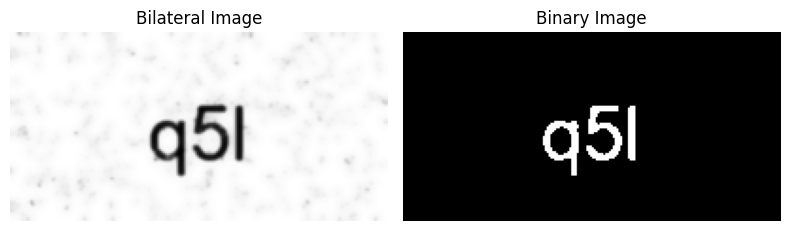

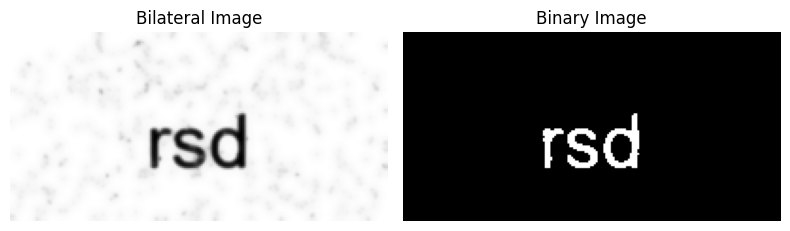

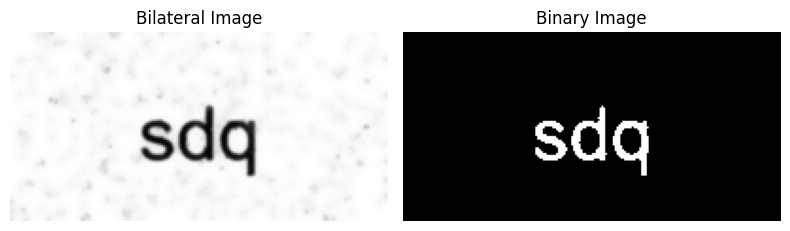

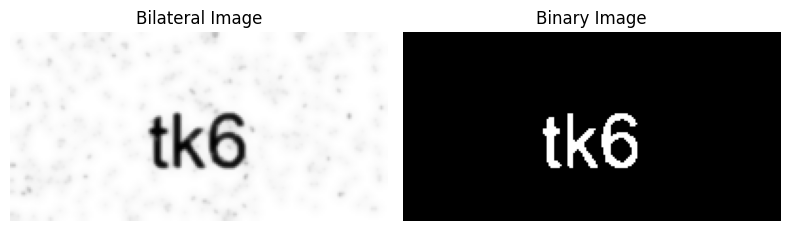

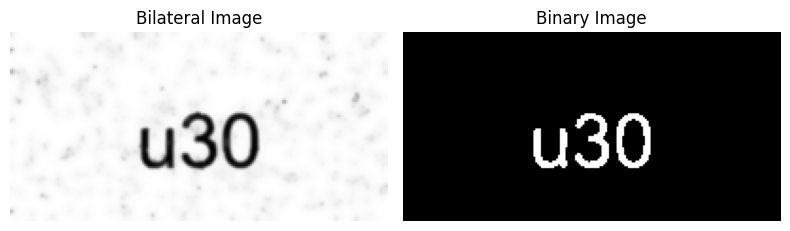

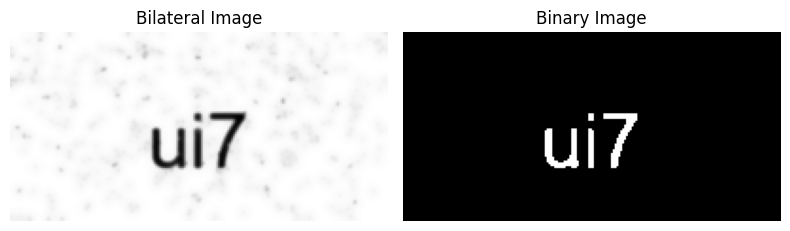

In [10]:
INPUT_DIR = "BilateralCaptcha"
OUTPUT_DIR = "BinaryCaptcha"
os.makedirs(OUTPUT_DIR, exist_ok=True)

BINARY_THRESHOLD = 140

for file in os.listdir(INPUT_DIR):
    if file.endswith(".png"):
        path = os.path.join(INPUT_DIR, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        _, binary = cv2.threshold(img, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY)
        binary = 255 - binary

        out_path = os.path.join(OUTPUT_DIR, file)
        cv2.imwrite(out_path, binary)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title("Bilateral Image")
        axes[0].axis("off")

        axes[1].imshow(binary, cmap='gray')
        axes[1].set_title("Binary Image")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
بخش سوم: بخش بندی
</p>


1t8_08.png → 3 characters detected


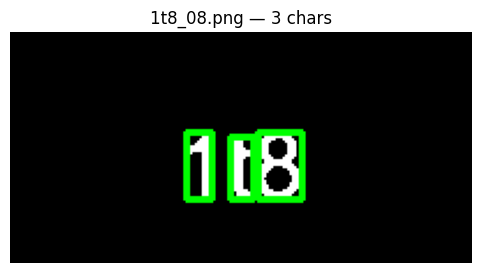

3xz_00.png → 3 characters detected


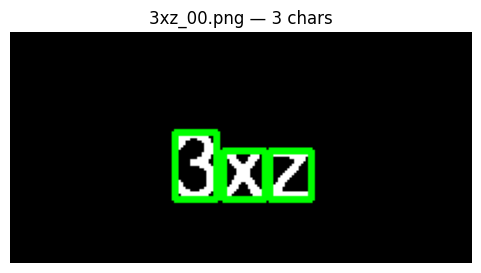

3y1_06.png → 3 characters detected


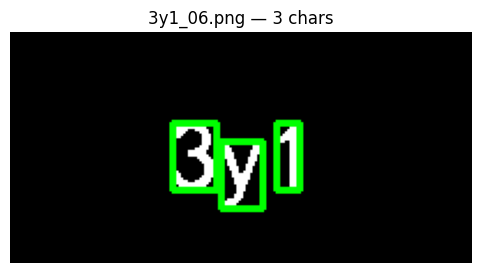

5yp_03.png → 3 characters detected


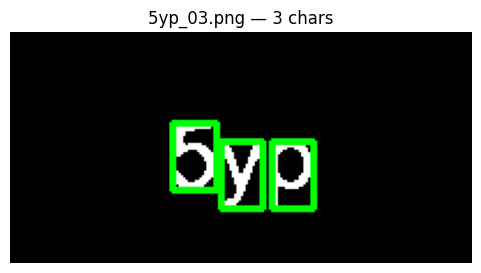

63p_07.png → 3 characters detected


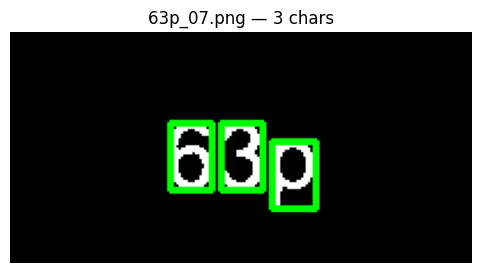

9o6_04.png → 3 characters detected


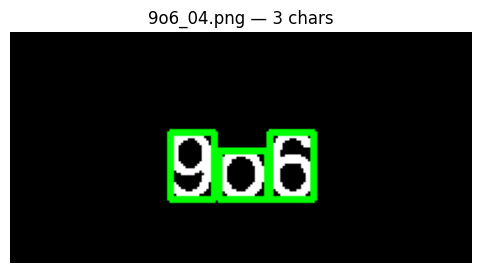

a6c_07.png → 3 characters detected


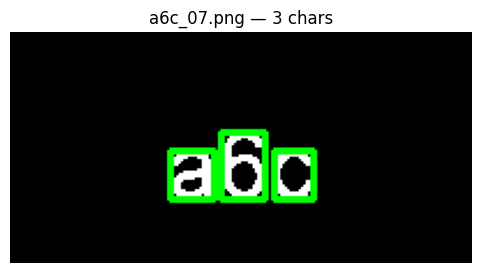

buc_02.png → 3 characters detected


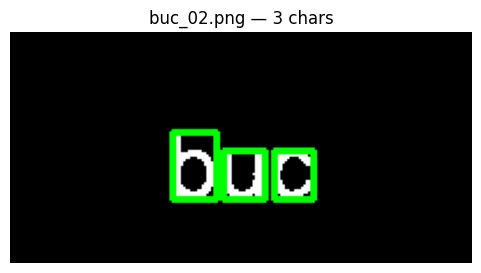

c5h_09.png → 3 characters detected


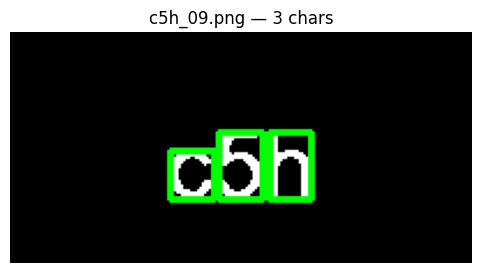

clc_01.png → 3 characters detected


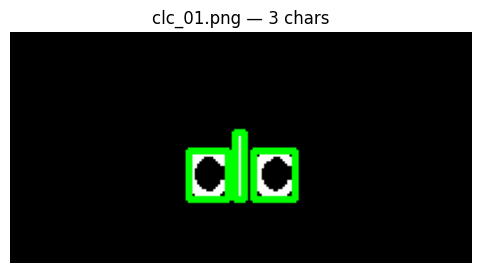

h4q_05.png → 3 characters detected


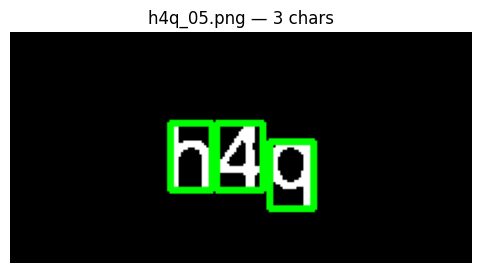

kte_03.png → 3 characters detected


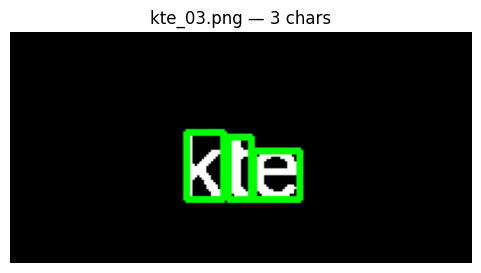

l4x_01.png → 3 characters detected


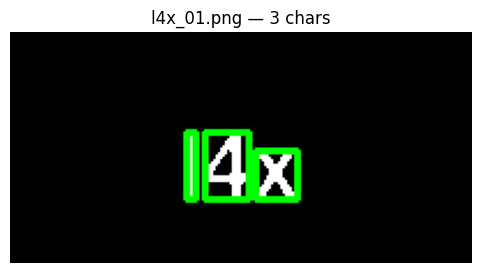

pj1_06.png → 3 characters detected


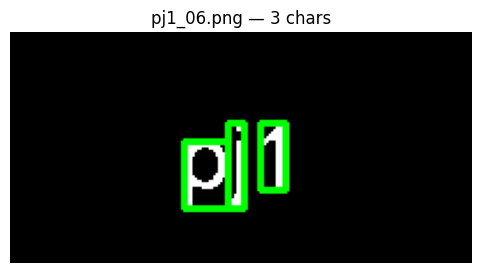

q5l_04.png → 3 characters detected


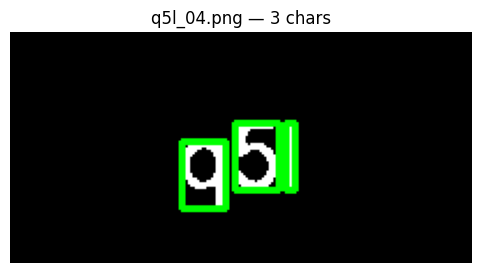

rsd_08.png → 3 characters detected


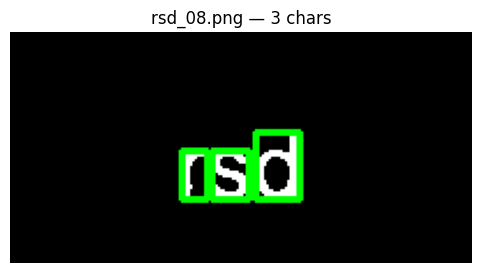

sdq_02.png → 3 characters detected


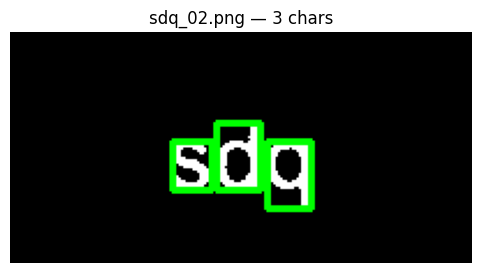

tk6_05.png → 3 characters detected


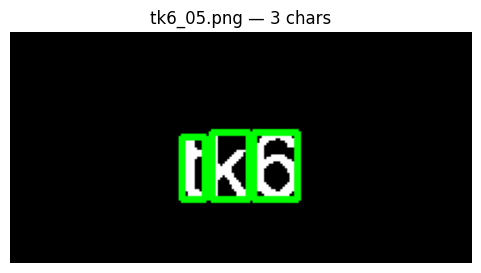

u30_00.png → 3 characters detected


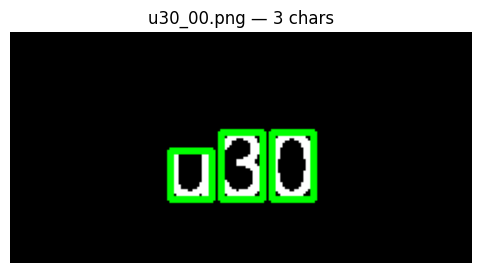

ui7_09.png → 3 characters detected


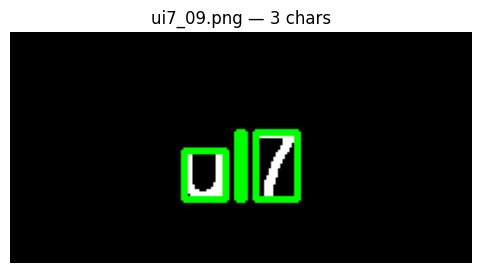

In [11]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

SOURCE_PATH = "BinaryCaptcha"
SEGMENTED_PATH = "Captcha_Segments"
os.makedirs(SEGMENTED_PATH, exist_ok=True)

AREA_LIMIT = 12
DIST_LIMIT = 2   
TARGET_SIZE = (64, 64)


def get_bounding_boxes(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w * h >= AREA_LIMIT:
            boxes.append((x, y, w, h))

    boxes = sorted(boxes, key=lambda b: b[0])
    return boxes


def join_close_boxes(boxes, max_dist=DIST_LIMIT): 
    if not boxes:
        return []
    combined = [boxes[0]]

    for (x, y, w, h) in boxes[1:]:
        last_x, last_y, last_w, last_h = combined[-1]
        center_last = last_x + last_w // 2
        center_now = x + w // 2
        if abs(center_now - center_last) <= max_dist:
            x_new = min(x, last_x)
            y_new = min(y, last_y)
            w_new = max(x + w, last_x + last_w) - x_new
            h_new = max(y + h, last_y + last_h) - y_new
            combined[-1] = (x_new, y_new, w_new, h_new)
        else:
            combined.append((x, y, w, h))
    return combined


def segment_image(filename):
    img_path = os.path.join(SOURCE_PATH, filename)
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    boxes = get_bounding_boxes(gray)
    merged = join_close_boxes(boxes, max_dist=DIST_LIMIT)

    print(f"{filename} → {len(merged)} characters detected")

    base = os.path.splitext(filename)[0]
    out_dir = os.path.join(SEGMENTED_PATH, base)
    os.makedirs(out_dir, exist_ok=True)

    vis = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in merged:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

    for i, (x, y, w, h) in enumerate(merged, 1):
        piece = gray[y:y+h, x:x+w]
        resized = cv2.resize(piece, TARGET_SIZE, interpolation=cv2.INTER_CUBIC)
        _, binary_piece = cv2.threshold(resized, 128, 255, cv2.THRESH_BINARY)
        out_path = os.path.join(out_dir, f"char_{i}.png")
        cv2.imwrite(out_path, binary_piece)

    plt.figure(figsize=(7, 3))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"{filename} — {len(merged)} chars")
    plt.axis("off")
    plt.show()


for f in os.listdir(SOURCE_PATH):
    if f.lower().endswith((".png", ".jpg", ".jpeg")):
        segment_image(f)


<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
ما باکس‌های نزدیک به هم را ادغام کردیم چون در تصاویر کپچا گاهی کاراکترها کاملاً از هم جدا نیستند و در نتیجه الگوریتم کانتور ممکن است چند بخش کوچک برای یک حرف شناسایی کند. به‌عنوان مثال، در حروفی مانند i یا j نقطه‌ی بالا به‌صورت یک کانتور مجزا تشخیص داده می‌شود، یا در حروفی با خطوط باریک ممکن است قسمت‌های شکسته به‌عنوان چند ناحیه مستقل در نظر گرفته شوند. برای جلوگیری از چنین اشتباهی، پس از شناسایی تمام جعبه‌های احاطه‌کننده‌ی کانتورها، فاصله‌ی افقی بین آن‌ها اندازه‌گیری شد و اگر این فاصله کمتر از مقدار آستانه‌ی تعیین‌شده (مثلاً چند پیکسل) بود، دو جعبه با هم ادغام شدند. به این ترتیب هر کاراکتر به‌صورت کامل و یک‌تکه استخراج می‌شود و از تقسیم نادرست یا تکرار غیرواقعی حروف جلوگیری می‌شود.
</p>


<p dir="rtl" style="line-height: 1.8; text-align: right; padding:10px; background-color:#6B7280;  border-radius: 12px; border: 2px solid rgb(2, 34, 22); font-family: Vazir;">
بخش چهارم: Recognition
</p>


In [15]:
import cv2
import numpy as np
import os
import csv

MAP_FOLDER = "Mapset"
SEGMENTS_FOLDER = "Captcha_Segments"
OUTPUT_CSV = "recognition_results.csv"

reference_images = {}
for filename in os.listdir(MAP_FOLDER):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        label = os.path.splitext(filename)[0]
        path = os.path.join(MAP_FOLDER, filename)
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        reference_images[label] = cv2.resize(image, (64, 64))

print(f" Reference characters loaded: {len(reference_images)} items found.")

def compute_correlation(im1, im2):
    im1, im2 = im1.astype(np.float32), im2.astype(np.float32)
    m1, m2 = np.mean(im1), np.mean(im2)
    numerator = np.sum((im1 - m1) * (im2 - m2))
    denominator = np.sqrt(np.sum((im1 - m1) ** 2) * np.sum((im2 - m2) ** 2))
    return numerator / denominator if denominator != 0 else 0.0

results = []

for captcha_dir in sorted(os.listdir(SEGMENTS_FOLDER)):
    full_captcha_path = os.path.join(SEGMENTS_FOLDER, captcha_dir)
    if not os.path.isdir(full_captcha_path):
        continue

    print(f"\nProcessing CAPTCHA: {captcha_dir}")
    files = sorted([f for f in os.listdir(full_captcha_path) if f.endswith(".png")])

    result_text = ""
    for idx, seg_file in enumerate(files, start=1):
        seg_path = os.path.join(full_captcha_path, seg_file)
        segment = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        segment = cv2.resize(segment, (64, 64))

        scores = {label: compute_correlation(segment, ref_img)
                  for label, ref_img in reference_images.items()}

        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        top_label, top_value = sorted_scores[0]
        result_text += top_label

        results.append([captcha_dir, seg_file, top_label, round(top_value, 4)])

        print(f"\nSegment {idx}: {seg_file}")
        print(f"{'Rank':<5}{'Char':<6}{'Score':<10}")
        for rank, (lbl, val) in enumerate(sorted_scores[:5], 1):
            print(f"{rank:<5}{lbl:<6}{val:<10.4f}")

    print(f"\nPredicted CAPTCHA text: {result_text}")

with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Captcha_Name", "Segment_File", "Predicted_Label", "Correlation_Score"])
    writer.writerows(results)

print(f"\nAll results saved to '{OUTPUT_CSV}'")


 Reference characters loaded: 36 items found.

Processing CAPTCHA: 1t8_08

Segment 1: char_1.png
Rank Char  Score     
1    1     0.8162    
2    q     0.3709    
3    n     0.2784    
4    d     0.2662    
5    u     0.1760    

Segment 2: char_2.png
Rank Char  Score     
1    t     0.7420    
2    f     0.4130    
3    z     0.3176    
4    y     0.2088    
5    x     0.1868    

Segment 3: char_3.png
Rank Char  Score     
1    8     0.6858    
2    6     0.5040    
3    3     0.4911    
4    g     0.4549    
5    9     0.4537    

Predicted CAPTCHA text: 1t8

Processing CAPTCHA: 3xz_00

Segment 1: char_1.png
Rank Char  Score     
1    3     0.6369    
2    8     0.5472    
3    a     0.4770    
4    9     0.4093    
5    s     0.3762    

Segment 2: char_2.png
Rank Char  Score     
1    x     0.7620    
2    z     0.3218    
3    y     0.2536    
4    g     0.1702    
5    7     0.1649    

Segment 3: char_3.png
Rank Char  Score     
1    z     0.7384    
2    7     0.4543    
3    